# Random Feature Model on Synthetic Dataset

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
class RF_NonLinear_Model(nn.Module):
    def __init__(self, p, d, o, coef):
        """RF_models
        
        Args:
            p (int): the hidden size
            d (int): the input feature dimension
            o (int): the output dimension
            coef (floatl): the ridge regression penalty coefficient
        """
        super(RF_NonLinear_Model, self).__init__()

        self.fc1 = nn.Linear(d, p, bias=False)
        stdv = 1
        self.fc1.weight.data.normal_(mean=0.0, std = stdv) # Gaussian initialization
        self.fc2 = nn.Linear(p, o, bias=False)
        self.p = p
        self.d = d
        self.o = o 
        self.coef = coef

    def forward(self, x):
        z = 1/np.sqrt(self.d) * F.relu(1/np.sqrt(self.d)* torch.mm(x, self.fc1.weight.data.t()))
        out = np.sqrt(self.d) * torch.mm(self.fc2.weight.data, z.t())
        return out.t()
    def optimize_second_layer(self, x, y):
        N = x.size(0)
        z = 1/np.sqrt(self.d) * F.relu(1/np.sqrt(self.d)* torch.mm(x, self.fc1.weight.data.t()))
        identity = torch.eye(self.p)
        identity = identity.to(x.device)
        beta = torch.mm(z.t(), z) + self.coef*self.p*N/(self.d**2) * identity
        beta = torch.mm(z, torch.inverse(beta))
        a = 1/np.sqrt(self.d) * torch.mm(y.t(), beta) 
        self.fc2.weight = torch.nn.Parameter(a)
        

In [2]:
import queue
class Ensemble_Two_Layer_NN(object):
    def __init__(self, n_classifiers, p, d=784, o=10, coef=1e-1):
        """Ensemble_Two_Layer_NN
        
        Args:
            p (int): the hidden size
            d (int, optional): the input feature dimension
            o (int, optional): the output dimension
            coef (float, optional): the ridge regression penalty coefficient
        """
        self.n_classifiers = n_classifiers
        self.p = p
        self.d = d 
        self.o = o 
        self.coef = coef
        self.learners = queue.LifoQueue(maxsize = self.n_classifiers)
        self.MODEL_TYPE = RF_NonLinear_Model
    def __len__(self):
        return len(self.learners.queue)
    
    def train_one_classifier(self, x, y):
        model = self.MODEL_TYPE(self.p, self.d, self.o, self.coef)
        if x.is_cuda:
            model.cuda()
        rho = 1/self.n_classifiers
        model.optimize_second_layer(x, y)
        self.learners.put([model, rho])
    def put_model_rho(self, model, rho):
        self.learners.put([model, rho])
    def get_init_model(self, cuda=True):
        model = self.MODEL_TYPE(self.p, self.d, self.o, self.coef)
        if cuda:
            model.cuda()
        return model
    def cuda(self):
        if len(self) == 0:
            return 
        else:
            for model, rho in self.learners.queue:
                model.cuda()
            return
    def train(self):
        if len(self)!=0:
            for model, rho in self.learners.queue:
                model.train()
    def eval(self):
        if len(self)!=0:
            for model, rho in self.learners.queue:
                model.eval()
    def forward(self, x):
        Bs = x.size(0)
        if len(self) == 0:
            zeros = torch.zeros(Bs, self.o)
            zeros = zeros.to(x.device)
            return zeros
        else:
            outputs = torch.zeros(Bs, self.o)
            outputs = outputs.to(x.device) 
            for model, rho in self.learners.queue:
                output = model(x)
                outputs += rho*output
            return outputs


In [3]:
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from typing import Type, Any, Callable, Union, List, Optional

def sample_true_distribution(feature_dim, output_dim, norm = 1):
    beta = np.random.multivariate_normal(np.zeros([feature_dim]), np.eye(feature_dim)/feature_dim, 
        size=(output_dim)).T
    beta = beta/np.linalg.norm(beta, ord=2) * norm # F norm = norm
    beta = beta.astype('float32')
    return beta
def random_draw_samples(beta, feature_dim, output_dim, num_samples):
    data = np.random.multivariate_normal(
        np.zeros([feature_dim])  , 
        np.eye(feature_dim), 
        size=(num_samples)) #X ~ N(0,1)
    data = data.astype('float32')
    targets = np.matmul(data, beta)
    targets = targets.astype('float32')
    return data, targets

def sample_nosie_to_data(data, targets, output_dim, variance):

    noises = np.random.multivariate_normal(
        np.zeros([output_dim]), 
        np.eye(output_dim)* (variance),
        size = (len(targets)))
    noises = noises.astype('float32')
    return data, targets + noises
def sample_dataset(feature_dim, output_dim, F_norm, SNR, num_samples, beta=None):

    if beta is None:
        beta = sample_true_distribution(feature_dim, output_dim, F_norm)
    data, targets = random_draw_samples(beta, feature_dim, output_dim, num_samples)
    if SNR !=0:
        variance = F_norm * SNR
        data, targets = sample_nosie_to_data(data, targets, output_dim, variance)
    return torch.from_numpy(data), torch.from_numpy(targets)
    


In [4]:
import os
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import copy 

# def get_subsample_dataset(trainset, subset):
#     trainsubset = copy.deepcopy(trainset)
#     trainsubset.data = [trainsubset.data[index] for index in subset]
#     trainsubset.targets = [trainsubset.targets[index] for index in subset]
#     return trainsubset
def fix_width_number(width, n_classifiers):
    return max(1, width//n_classifiers)

# Training
def train(net, train_beta, train_size, feature_dim, output_dim, F_norm, SNR):
    net.train()
    train_loss = 0
    correct = 0
    trainset = sample_dataset(feature_dim, output_dim, F_norm, SNR, train_size, beta = train_beta)
    trainset = TensorDataset(*trainset)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=True)
    trainloader = iter(trainloader)
    with torch.no_grad():
        inputs, targets = next(trainloader)
        Bs = inputs.size(0)
        inputs = inputs.reshape(Bs, -1)
        inputs, targets = inputs.cuda(), targets.cuda()
        for _ in range(net.n_classifiers):
            net.train_one_classifier(inputs, targets)
        outputs = net.forward(inputs)
        loss = criterion(outputs, targets)
        train_loss = loss.item() * outputs.numel()
        total = targets.size(0)
    return train_loss/ total

# Test
def test(net, testloader):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            Bs = inputs.size(0)
            inputs = inputs.reshape(Bs, -1)
            outputs = net.forward(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * outputs.numel()
            total += targets.size(0)
    return test_loss / total

def compute_bias_variance(net, testloader, trial, OUTPUST_SUM, OUTPUTS_SUMNORMSQUARED):
    net.eval()
    bias2 = 0
    variance = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            Bs = inputs.size(0)
            inputs = inputs.reshape(Bs, -1)
            outputs = net.forward(inputs)
            OUTPUST_SUM[total:(total + targets.size(0)), :] += outputs
            OUTPUTS_SUMNORMSQUARED[total:total + targets.size(0)] += outputs.norm(dim=1) ** 2.0

            bias2 += (OUTPUST_SUM[total:total + targets.size(0), :] / (trial + 1) - targets).norm() ** 2.0
            variance += OUTPUTS_SUMNORMSQUARED[total:total + targets.size(0)].sum()/(trial + 1) - (OUTPUST_SUM[total:total + targets.size(0), :]/(trial + 1)).norm() ** 2.0
            total += targets.size(0)

    return bias2 / total, variance / total

Define the synthetic dataset:
$y=X\beta + \epsilon_\mu, ||\beta|| = F, \epsilon_{mu} ~ \mathcal{N}(0, 1), SNR = F/\tau$

In [5]:
import pandas as pd
feature_dim = 400
num_classes = 1
SNR = 1
test_size = 10000
beta = sample_true_distribution(feature_dim, num_classes, norm = 1)
#trainset = Synthetic_Dataset(feature_dim=feature_dim, output_dim=1, num_samples=50000, seed=10, SNR = SNR)
testset = sample_dataset(feature_dim, num_classes, F_norm = 1, SNR =0., num_samples=test_size, beta = beta)
testset = TensorDataset(*testset)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)
# loss definition
criterion = nn.MSELoss(reduction='mean').cuda()

num_trials = 50
coef = 0.01
N_Ds = [1]
train_sizes = [int(np.around(x*feature_dim)) for x in N_Ds]
P_Ns = 10** np.linspace(-2, 1, 50)

outdir = 'synthetic_coef_{}'.format(coef)
if not os.path.exists(outdir):
    os.makedirs(outdir)

def run_exps_ridge(train_sizes, N_Ds, P_Ns, train_beta, test_size, feature_dim, num_classes, num_trials, coef,
             outdir, save_csv, SNR, K = 1, F_norm= 1):
    df = pd.DataFrame()
    # When training single NN
    for train_size in train_sizes:
        hidden_sizes = P_Ns * train_size
        hidden_sizes = np.unique([int(np.around(x)) for x in hidden_sizes])
        for hidden_size in hidden_sizes:
            TRAIN_LOSS_SUM = 0.0
            TEST_LOSS_SUM = 0.0
            #permute_index = np.random.permutation(len(trainset))
            OUTPUST_SUM = torch.Tensor(test_size, num_classes).zero_().cuda()
            OUTPUTS_SUMNORMSQUARED = torch.Tensor(test_size).zero_().cuda()
            for trial in range(num_trials):
                net = Ensemble_Two_Layer_NN(n_classifiers = K, p = fix_width_number(hidden_size, K), d=feature_dim, o=num_classes, coef=coef)
                net.cuda()
                train_loss = train(net, train_beta, train_size, feature_dim, num_classes, F_norm, SNR)
                test_loss = test(net, testloader)

                TRAIN_LOSS_SUM += train_loss
                TEST_LOSS_SUM += test_loss

                # compute bias and variance
                bias2, variance = compute_bias_variance(net, testloader, trial, OUTPUST_SUM, OUTPUTS_SUMNORMSQUARED)
                variance_unbias = variance * num_trials / (num_trials - 1.0)
                bias2_unbias = TEST_LOSS_SUM / (trial + 1) - variance_unbias
                print('Train size: [{}] hidden size: [{}] trial: {}, train_loss: {:.6f}, test loss: {:.6f}, bias2: {}, variance: {}'.format(
                    train_size, hidden_size,
                    trial, TRAIN_LOSS_SUM / (trial + 1),  TEST_LOSS_SUM / (trial + 1),
                    bias2_unbias, variance_unbias))
                torch.cuda.empty_cache()
            print('#'*50)
            df = df.append({'train_size': train_size, 'hidden_size':hidden_size, 
                            'train_loss': TRAIN_LOSS_SUM / (trial + 1), 
                            'test_loss': TEST_LOSS_SUM / (trial + 1), 
                           'variance': variance_unbias.item(),
                           'bias2': bias2_unbias.item()}, ignore_index=True)
            df.to_csv(os.path.join(outdir, save_csv))
    df.to_csv(os.path.join(outdir, save_csv))


In [6]:
run_exps_ridge(train_sizes, N_Ds, P_Ns, beta, test_size, feature_dim, num_classes, num_trials, coef,
             outdir, 'singleNN_output.csv', SNR= SNR, K = 1, F_norm = 1)

Train size: [400] hidden size: [4] trial: 0, train_loss: 2.123276, test loss: 1.002749, bias2: 1.0027494430541992, variance: 0.0
Train size: [400] hidden size: [4] trial: 1, train_loss: 2.111441, test loss: 0.995584, bias2: 0.9811515212059021, variance: 0.014432883821427822
Train size: [400] hidden size: [4] trial: 2, train_loss: 2.072924, test loss: 0.999493, bias2: 0.9855545163154602, variance: 0.0139383003115654
Train size: [400] hidden size: [4] trial: 3, train_loss: 2.124720, test loss: 1.006568, bias2: 0.9885440468788147, variance: 0.018023541197180748
Train size: [400] hidden size: [4] trial: 4, train_loss: 2.115449, test loss: 1.009124, bias2: 0.9861704707145691, variance: 0.02295321598649025
Train size: [400] hidden size: [4] trial: 5, train_loss: 2.050113, test loss: 1.009065, bias2: 0.9869535565376282, variance: 0.0221118051558733
Train size: [400] hidden size: [4] trial: 6, train_loss: 2.027403, test loss: 1.009730, bias2: 0.9885431528091431, variance: 0.02118685655295849
T

Train size: [400] hidden size: [5] trial: 6, train_loss: 1.910596, test loss: 1.035590, bias2: 0.9988950490951538, variance: 0.03669526427984238
Train size: [400] hidden size: [5] trial: 7, train_loss: 1.933857, test loss: 1.035917, bias2: 0.9970105886459351, variance: 0.03890598565340042
Train size: [400] hidden size: [5] trial: 8, train_loss: 1.968013, test loss: 1.034248, bias2: 0.9961084127426147, variance: 0.03813984990119934
Train size: [400] hidden size: [5] trial: 9, train_loss: 1.956436, test loss: 1.035287, bias2: 0.9966738224029541, variance: 0.03861329331994057
Train size: [400] hidden size: [5] trial: 10, train_loss: 1.939420, test loss: 1.036898, bias2: 0.9971624612808228, variance: 0.03973570093512535
Train size: [400] hidden size: [5] trial: 11, train_loss: 1.940461, test loss: 1.034283, bias2: 0.9964894652366638, variance: 0.037793103605508804
Train size: [400] hidden size: [5] trial: 12, train_loss: 1.964419, test loss: 1.033358, bias2: 0.9960460662841797, variance: 0

Train size: [400] hidden size: [6] trial: 12, train_loss: 1.996232, test loss: 1.020433, bias2: 0.989016056060791, variance: 0.0314168855547905
Train size: [400] hidden size: [6] trial: 13, train_loss: 1.988262, test loss: 1.020601, bias2: 0.9891741871833801, variance: 0.031426701694726944
Train size: [400] hidden size: [6] trial: 14, train_loss: 1.989768, test loss: 1.022780, bias2: 0.9898362159729004, variance: 0.0329439602792263
Train size: [400] hidden size: [6] trial: 15, train_loss: 1.998276, test loss: 1.024321, bias2: 0.989597737789154, variance: 0.03472370281815529
Train size: [400] hidden size: [6] trial: 16, train_loss: 1.978723, test loss: 1.027201, bias2: 0.9897540211677551, variance: 0.037446655333042145
Train size: [400] hidden size: [6] trial: 17, train_loss: 1.978566, test loss: 1.026097, bias2: 0.9903647899627686, variance: 0.03573225438594818
Train size: [400] hidden size: [6] trial: 18, train_loss: 1.982897, test loss: 1.024806, bias2: 0.9887753129005432, variance: 

Train size: [400] hidden size: [7] trial: 18, train_loss: 1.956773, test loss: 1.024005, bias2: 0.9807645678520203, variance: 0.0432407446205616
Train size: [400] hidden size: [7] trial: 19, train_loss: 1.939363, test loss: 1.024471, bias2: 0.9820237159729004, variance: 0.042447082698345184
Train size: [400] hidden size: [7] trial: 20, train_loss: 1.942600, test loss: 1.024809, bias2: 0.9807628393173218, variance: 0.04404642432928085
Train size: [400] hidden size: [7] trial: 21, train_loss: 1.945725, test loss: 1.024340, bias2: 0.9813212752342224, variance: 0.04301873594522476
Train size: [400] hidden size: [7] trial: 22, train_loss: 1.950868, test loss: 1.022721, bias2: 0.9783960580825806, variance: 0.04432525858283043
Train size: [400] hidden size: [7] trial: 23, train_loss: 1.957333, test loss: 1.023422, bias2: 0.9786838889122009, variance: 0.044737864285707474
Train size: [400] hidden size: [7] trial: 24, train_loss: 1.958199, test loss: 1.022432, bias2: 0.9772244691848755, varianc

Train size: [400] hidden size: [8] trial: 24, train_loss: 1.946859, test loss: 1.026420, bias2: 0.9783458113670349, variance: 0.04807432368397713
Train size: [400] hidden size: [8] trial: 25, train_loss: 1.941560, test loss: 1.025967, bias2: 0.9779288172721863, variance: 0.04803771153092384
Train size: [400] hidden size: [8] trial: 26, train_loss: 1.939224, test loss: 1.025024, bias2: 0.9783523082733154, variance: 0.04667196422815323
Train size: [400] hidden size: [8] trial: 27, train_loss: 1.933392, test loss: 1.025260, bias2: 0.9778096079826355, variance: 0.04744987562298775
Train size: [400] hidden size: [8] trial: 28, train_loss: 1.928246, test loss: 1.025424, bias2: 0.9770829081535339, variance: 0.048341117799282074
Train size: [400] hidden size: [8] trial: 29, train_loss: 1.938415, test loss: 1.025433, bias2: 0.9776405692100525, variance: 0.04779203608632088
Train size: [400] hidden size: [8] trial: 30, train_loss: 1.934934, test loss: 1.025320, bias2: 0.9770796298980713, varianc

Train size: [400] hidden size: [9] trial: 30, train_loss: 1.929111, test loss: 1.040866, bias2: 0.9729461073875427, variance: 0.0679200291633606
Train size: [400] hidden size: [9] trial: 31, train_loss: 1.922243, test loss: 1.040203, bias2: 0.973639965057373, variance: 0.06656338274478912
Train size: [400] hidden size: [9] trial: 32, train_loss: 1.921280, test loss: 1.041185, bias2: 0.9734600782394409, variance: 0.0677245706319809
Train size: [400] hidden size: [9] trial: 33, train_loss: 1.922467, test loss: 1.040520, bias2: 0.9742769002914429, variance: 0.06624268740415573
Train size: [400] hidden size: [9] trial: 34, train_loss: 1.935058, test loss: 1.040940, bias2: 0.9740379452705383, variance: 0.06690186262130737
Train size: [400] hidden size: [9] trial: 35, train_loss: 1.932220, test loss: 1.040651, bias2: 0.9735366702079773, variance: 0.06711454689502716
Train size: [400] hidden size: [9] trial: 36, train_loss: 1.934427, test loss: 1.040314, bias2: 0.9723333716392517, variance: 0

Train size: [400] hidden size: [11] trial: 36, train_loss: 1.916033, test loss: 1.039667, bias2: 0.9670467376708984, variance: 0.07262053340673447
Train size: [400] hidden size: [11] trial: 37, train_loss: 1.920278, test loss: 1.039753, bias2: 0.9666649103164673, variance: 0.07308843731880188
Train size: [400] hidden size: [11] trial: 38, train_loss: 1.919658, test loss: 1.040022, bias2: 0.9670408964157104, variance: 0.07298064231872559
Train size: [400] hidden size: [11] trial: 39, train_loss: 1.917819, test loss: 1.038929, bias2: 0.9669142961502075, variance: 0.07201468199491501
Train size: [400] hidden size: [11] trial: 40, train_loss: 1.916435, test loss: 1.038188, bias2: 0.9662489891052246, variance: 0.07193896919488907
Train size: [400] hidden size: [11] trial: 41, train_loss: 1.918171, test loss: 1.037459, bias2: 0.9654561281204224, variance: 0.07200325280427933
Train size: [400] hidden size: [11] trial: 42, train_loss: 1.911768, test loss: 1.037908, bias2: 0.9657424688339233, v

Train size: [400] hidden size: [12] trial: 42, train_loss: 1.931759, test loss: 1.051327, bias2: 0.9601800441741943, variance: 0.0911470502614975
Train size: [400] hidden size: [12] trial: 43, train_loss: 1.935282, test loss: 1.051222, bias2: 0.9607346057891846, variance: 0.09048710018396378
Train size: [400] hidden size: [12] trial: 44, train_loss: 1.931520, test loss: 1.050537, bias2: 0.9597750902175903, variance: 0.09076213836669922
Train size: [400] hidden size: [12] trial: 45, train_loss: 1.932947, test loss: 1.050581, bias2: 0.9593248963356018, variance: 0.09125596284866333
Train size: [400] hidden size: [12] trial: 46, train_loss: 1.934458, test loss: 1.051371, bias2: 0.9592214226722717, variance: 0.09214930236339569
Train size: [400] hidden size: [12] trial: 47, train_loss: 1.932395, test loss: 1.050016, bias2: 0.9587795734405518, variance: 0.09123681485652924
Train size: [400] hidden size: [12] trial: 48, train_loss: 1.935410, test loss: 1.050884, bias2: 0.9588868021965027, va

Train size: [400] hidden size: [14] trial: 48, train_loss: 1.884846, test loss: 1.049860, bias2: 0.9517560601234436, variance: 0.09810380637645721
Train size: [400] hidden size: [14] trial: 49, train_loss: 1.882843, test loss: 1.049135, bias2: 0.9514169692993164, variance: 0.09771838039159775
##################################################
Train size: [400] hidden size: [16] trial: 0, train_loss: 1.952538, test loss: 1.013536, bias2: 1.013535976409912, variance: 3.8925479506346505e-10
Train size: [400] hidden size: [16] trial: 1, train_loss: 1.958751, test loss: 1.026636, bias2: 0.9822883605957031, variance: 0.04434773325920105
Train size: [400] hidden size: [16] trial: 2, train_loss: 1.957722, test loss: 1.049992, bias2: 0.9716265201568604, variance: 0.07836533337831497
Train size: [400] hidden size: [16] trial: 3, train_loss: 1.966303, test loss: 1.045470, bias2: 0.9704707860946655, variance: 0.07499959319829941
Train size: [400] hidden size: [16] trial: 4, train_loss: 1.978346, t

Train size: [400] hidden size: [19] trial: 4, train_loss: 2.044917, test loss: 1.072772, bias2: 0.9570097923278809, variance: 0.11576201021671295
Train size: [400] hidden size: [19] trial: 5, train_loss: 2.031657, test loss: 1.071643, bias2: 0.9443796873092651, variance: 0.12726333737373352
Train size: [400] hidden size: [19] trial: 6, train_loss: 1.996367, test loss: 1.072050, bias2: 0.944625198841095, variance: 0.127424418926239
Train size: [400] hidden size: [19] trial: 7, train_loss: 1.985337, test loss: 1.075367, bias2: 0.9440938234329224, variance: 0.13127294182777405
Train size: [400] hidden size: [19] trial: 8, train_loss: 1.962478, test loss: 1.068419, bias2: 0.9420040845870972, variance: 0.12641537189483643
Train size: [400] hidden size: [19] trial: 9, train_loss: 1.960027, test loss: 1.071357, bias2: 0.9434421062469482, variance: 0.1279146522283554
Train size: [400] hidden size: [19] trial: 10, train_loss: 1.945716, test loss: 1.069408, bias2: 0.9392907619476318, variance: 0

Train size: [400] hidden size: [22] trial: 10, train_loss: 1.850543, test loss: 1.067524, bias2: 0.9263657331466675, variance: 0.14115847647190094
Train size: [400] hidden size: [22] trial: 11, train_loss: 1.840175, test loss: 1.069882, bias2: 0.9260194897651672, variance: 0.1438625305891037
Train size: [400] hidden size: [22] trial: 12, train_loss: 1.846291, test loss: 1.072447, bias2: 0.9242030382156372, variance: 0.1482439935207367
Train size: [400] hidden size: [22] trial: 13, train_loss: 1.840611, test loss: 1.071270, bias2: 0.9206459522247314, variance: 0.15062390267848969
Train size: [400] hidden size: [22] trial: 14, train_loss: 1.837814, test loss: 1.072708, bias2: 0.9148956537246704, variance: 0.1578127145767212
Train size: [400] hidden size: [22] trial: 15, train_loss: 1.843554, test loss: 1.080498, bias2: 0.9131683111190796, variance: 0.16732928156852722
Train size: [400] hidden size: [22] trial: 16, train_loss: 1.851859, test loss: 1.078191, bias2: 0.9138941764831543, vari

Train size: [400] hidden size: [25] trial: 16, train_loss: 1.904795, test loss: 1.082646, bias2: 0.9241929650306702, variance: 0.1584525853395462
Train size: [400] hidden size: [25] trial: 17, train_loss: 1.896581, test loss: 1.080188, bias2: 0.922661304473877, variance: 0.15752647817134857
Train size: [400] hidden size: [25] trial: 18, train_loss: 1.904177, test loss: 1.081314, bias2: 0.9217374920845032, variance: 0.15957635641098022
Train size: [400] hidden size: [25] trial: 19, train_loss: 1.896793, test loss: 1.080276, bias2: 0.919685423374176, variance: 0.16059021651744843
Train size: [400] hidden size: [25] trial: 20, train_loss: 1.904889, test loss: 1.083720, bias2: 0.9182732105255127, variance: 0.16544723510742188
Train size: [400] hidden size: [25] trial: 21, train_loss: 1.900744, test loss: 1.082474, bias2: 0.9175490140914917, variance: 0.16492484509944916
Train size: [400] hidden size: [25] trial: 22, train_loss: 1.912241, test loss: 1.084109, bias2: 0.9150923490524292, vari

Train size: [400] hidden size: [29] trial: 22, train_loss: 1.786591, test loss: 1.104613, bias2: 0.8942539095878601, variance: 0.21035951375961304
Train size: [400] hidden size: [29] trial: 23, train_loss: 1.783497, test loss: 1.106808, bias2: 0.8915223479270935, variance: 0.21528582274913788
Train size: [400] hidden size: [29] trial: 24, train_loss: 1.774092, test loss: 1.104835, bias2: 0.892920732498169, variance: 0.21191462874412537
Train size: [400] hidden size: [29] trial: 25, train_loss: 1.783383, test loss: 1.105720, bias2: 0.8963922262191772, variance: 0.20932747423648834
Train size: [400] hidden size: [29] trial: 26, train_loss: 1.778113, test loss: 1.104883, bias2: 0.8968732953071594, variance: 0.20801003277301788
Train size: [400] hidden size: [29] trial: 27, train_loss: 1.770894, test loss: 1.104400, bias2: 0.8966562747955322, variance: 0.20774391293525696
Train size: [400] hidden size: [29] trial: 28, train_loss: 1.778534, test loss: 1.103057, bias2: 0.8957309722900391, va

Train size: [400] hidden size: [33] trial: 28, train_loss: 1.778631, test loss: 1.109477, bias2: 0.9017825126647949, variance: 0.2076941728591919
Train size: [400] hidden size: [33] trial: 29, train_loss: 1.777427, test loss: 1.109449, bias2: 0.90220707654953, variance: 0.20724241435527802
Train size: [400] hidden size: [33] trial: 30, train_loss: 1.772207, test loss: 1.109851, bias2: 0.9019090533256531, variance: 0.2079417109489441
Train size: [400] hidden size: [33] trial: 31, train_loss: 1.779659, test loss: 1.109690, bias2: 0.9025506377220154, variance: 0.20713895559310913
Train size: [400] hidden size: [33] trial: 32, train_loss: 1.777308, test loss: 1.107556, bias2: 0.8996281027793884, variance: 0.2079276591539383
Train size: [400] hidden size: [33] trial: 33, train_loss: 1.776878, test loss: 1.105579, bias2: 0.8969696164131165, variance: 0.20860929787158966
Train size: [400] hidden size: [33] trial: 34, train_loss: 1.776370, test loss: 1.106898, bias2: 0.898090660572052, varianc

Train size: [400] hidden size: [38] trial: 34, train_loss: 1.707742, test loss: 1.121343, bias2: 0.8839413523674011, variance: 0.23740142583847046
Train size: [400] hidden size: [38] trial: 35, train_loss: 1.715239, test loss: 1.122096, bias2: 0.8848575949668884, variance: 0.23723846673965454
Train size: [400] hidden size: [38] trial: 36, train_loss: 1.711032, test loss: 1.120855, bias2: 0.8850791454315186, variance: 0.23577572405338287
Train size: [400] hidden size: [38] trial: 37, train_loss: 1.712949, test loss: 1.119380, bias2: 0.8845939040184021, variance: 0.2347862273454666
Train size: [400] hidden size: [38] trial: 38, train_loss: 1.718179, test loss: 1.118458, bias2: 0.8841208219528198, variance: 0.2343369871377945
Train size: [400] hidden size: [38] trial: 39, train_loss: 1.716538, test loss: 1.119379, bias2: 0.8816168308258057, variance: 0.2377617508172989
Train size: [400] hidden size: [38] trial: 40, train_loss: 1.714986, test loss: 1.120278, bias2: 0.8805490136146545, vari

Train size: [400] hidden size: [44] trial: 40, train_loss: 1.736560, test loss: 1.167844, bias2: 0.8596116900444031, variance: 0.30823224782943726
Train size: [400] hidden size: [44] trial: 41, train_loss: 1.734150, test loss: 1.169758, bias2: 0.8590302467346191, variance: 0.3107277452945709
Train size: [400] hidden size: [44] trial: 42, train_loss: 1.731062, test loss: 1.167706, bias2: 0.8588885068893433, variance: 0.30881765484809875
Train size: [400] hidden size: [44] trial: 43, train_loss: 1.736908, test loss: 1.167481, bias2: 0.8553873896598816, variance: 0.3120940327644348
Train size: [400] hidden size: [44] trial: 44, train_loss: 1.730828, test loss: 1.167305, bias2: 0.8559997081756592, variance: 0.31130561232566833
Train size: [400] hidden size: [44] trial: 45, train_loss: 1.728473, test loss: 1.166618, bias2: 0.8558740615844727, variance: 0.3107440173625946
Train size: [400] hidden size: [44] trial: 46, train_loss: 1.726973, test loss: 1.166608, bias2: 0.8571232557296753, vari

Train size: [400] hidden size: [51] trial: 46, train_loss: 1.688581, test loss: 1.186375, bias2: 0.8162006139755249, variance: 0.3701740503311157
Train size: [400] hidden size: [51] trial: 47, train_loss: 1.685442, test loss: 1.187426, bias2: 0.8169177770614624, variance: 0.3705086410045624
Train size: [400] hidden size: [51] trial: 48, train_loss: 1.681360, test loss: 1.186898, bias2: 0.8160126209259033, variance: 0.3708849847316742
Train size: [400] hidden size: [51] trial: 49, train_loss: 1.683411, test loss: 1.187354, bias2: 0.8172155618667603, variance: 0.3701383173465729
##################################################
Train size: [400] hidden size: [58] trial: 0, train_loss: 1.714040, test loss: 1.286266, bias2: 1.2862656116485596, variance: -1.5570191802538602e-09
Train size: [400] hidden size: [58] trial: 1, train_loss: 1.670721, test loss: 1.311615, bias2: 1.0400817394256592, variance: 0.2715334892272949
Train size: [400] hidden size: [58] trial: 2, train_loss: 1.625967, te

Train size: [400] hidden size: [67] trial: 2, train_loss: 1.598203, test loss: 1.248173, bias2: 0.922634482383728, variance: 0.3255387544631958
Train size: [400] hidden size: [67] trial: 3, train_loss: 1.582941, test loss: 1.217524, bias2: 0.8831616640090942, variance: 0.3343621492385864
Train size: [400] hidden size: [67] trial: 4, train_loss: 1.601967, test loss: 1.206027, bias2: 0.866450309753418, variance: 0.3395765721797943
Train size: [400] hidden size: [67] trial: 5, train_loss: 1.587493, test loss: 1.221796, bias2: 0.8500412702560425, variance: 0.37175452709198
Train size: [400] hidden size: [67] trial: 6, train_loss: 1.577626, test loss: 1.239252, bias2: 0.8332859873771667, variance: 0.40596574544906616
Train size: [400] hidden size: [67] trial: 7, train_loss: 1.562356, test loss: 1.224834, bias2: 0.8271572589874268, variance: 0.3976761996746063
Train size: [400] hidden size: [67] trial: 8, train_loss: 1.560043, test loss: 1.222158, bias2: 0.8130727410316467, variance: 0.40908

Train size: [400] hidden size: [77] trial: 8, train_loss: 1.515726, test loss: 1.275817, bias2: 0.8057231307029724, variance: 0.47009390592575073
Train size: [400] hidden size: [77] trial: 9, train_loss: 1.534975, test loss: 1.283290, bias2: 0.7993719577789307, variance: 0.483918160200119
Train size: [400] hidden size: [77] trial: 10, train_loss: 1.549896, test loss: 1.294224, bias2: 0.7944775819778442, variance: 0.4997466504573822
Train size: [400] hidden size: [77] trial: 11, train_loss: 1.555530, test loss: 1.281683, bias2: 0.7827614545822144, variance: 0.4989219903945923
Train size: [400] hidden size: [77] trial: 12, train_loss: 1.563309, test loss: 1.280939, bias2: 0.7815530896186829, variance: 0.49938565492630005
Train size: [400] hidden size: [77] trial: 13, train_loss: 1.553222, test loss: 1.276967, bias2: 0.7772270441055298, variance: 0.4997403621673584
Train size: [400] hidden size: [77] trial: 14, train_loss: 1.551651, test loss: 1.276188, bias2: 0.7759291529655457, variance

Train size: [400] hidden size: [89] trial: 14, train_loss: 1.386098, test loss: 1.374072, bias2: 0.7565780282020569, variance: 0.6174941658973694
Train size: [400] hidden size: [89] trial: 15, train_loss: 1.390471, test loss: 1.381407, bias2: 0.7556238174438477, variance: 0.6257827281951904
Train size: [400] hidden size: [89] trial: 16, train_loss: 1.396783, test loss: 1.383336, bias2: 0.7556243538856506, variance: 0.6277113556861877
Train size: [400] hidden size: [89] trial: 17, train_loss: 1.404288, test loss: 1.376451, bias2: 0.7474954128265381, variance: 0.6289553642272949
Train size: [400] hidden size: [89] trial: 18, train_loss: 1.405781, test loss: 1.385119, bias2: 0.7428678274154663, variance: 0.6422508955001831
Train size: [400] hidden size: [89] trial: 19, train_loss: 1.403727, test loss: 1.385717, bias2: 0.7389131784439087, variance: 0.6468034982681274
Train size: [400] hidden size: [89] trial: 20, train_loss: 1.407148, test loss: 1.387196, bias2: 0.7413883209228516, varianc

Train size: [400] hidden size: [102] trial: 20, train_loss: 1.375236, test loss: 1.450846, bias2: 0.702909529209137, variance: 0.7479363083839417
Train size: [400] hidden size: [102] trial: 21, train_loss: 1.379934, test loss: 1.453807, bias2: 0.7055882215499878, variance: 0.7482188940048218
Train size: [400] hidden size: [102] trial: 22, train_loss: 1.376418, test loss: 1.459921, bias2: 0.7092182636260986, variance: 0.7507032155990601
Train size: [400] hidden size: [102] trial: 23, train_loss: 1.378648, test loss: 1.457776, bias2: 0.7104787230491638, variance: 0.747297465801239
Train size: [400] hidden size: [102] trial: 24, train_loss: 1.378407, test loss: 1.453539, bias2: 0.7048174738883972, variance: 0.7487213015556335
Train size: [400] hidden size: [102] trial: 25, train_loss: 1.373961, test loss: 1.459908, bias2: 0.7030725479125977, variance: 0.7568352222442627
Train size: [400] hidden size: [102] trial: 26, train_loss: 1.368840, test loss: 1.464639, bias2: 0.7014890909194946, va

Train size: [400] hidden size: [118] trial: 26, train_loss: 1.272452, test loss: 1.517497, bias2: 0.6633008122444153, variance: 0.8541956543922424
Train size: [400] hidden size: [118] trial: 27, train_loss: 1.270700, test loss: 1.512946, bias2: 0.6583154201507568, variance: 0.8546308279037476
Train size: [400] hidden size: [118] trial: 28, train_loss: 1.266293, test loss: 1.513899, bias2: 0.6570478677749634, variance: 0.8568507432937622
Train size: [400] hidden size: [118] trial: 29, train_loss: 1.276211, test loss: 1.516900, bias2: 0.653408944606781, variance: 0.863490879535675
Train size: [400] hidden size: [118] trial: 30, train_loss: 1.279309, test loss: 1.516188, bias2: 0.6538226008415222, variance: 0.8623655438423157
Train size: [400] hidden size: [118] trial: 31, train_loss: 1.277670, test loss: 1.510388, bias2: 0.651538610458374, variance: 0.858849048614502
Train size: [400] hidden size: [118] trial: 32, train_loss: 1.275565, test loss: 1.512689, bias2: 0.6536585092544556, vari

Train size: [400] hidden size: [136] trial: 32, train_loss: 1.120533, test loss: 1.596169, bias2: 0.6121343970298767, variance: 0.9840349555015564
Train size: [400] hidden size: [136] trial: 33, train_loss: 1.123070, test loss: 1.601888, bias2: 0.6134393215179443, variance: 0.9884486198425293
Train size: [400] hidden size: [136] trial: 34, train_loss: 1.120634, test loss: 1.609433, bias2: 0.6112459897994995, variance: 0.998186469078064
Train size: [400] hidden size: [136] trial: 35, train_loss: 1.124983, test loss: 1.611999, bias2: 0.6104903221130371, variance: 1.001508355140686
Train size: [400] hidden size: [136] trial: 36, train_loss: 1.120161, test loss: 1.609710, bias2: 0.6062543392181396, variance: 1.0034552812576294
Train size: [400] hidden size: [136] trial: 37, train_loss: 1.121080, test loss: 1.615613, bias2: 0.6046313047409058, variance: 1.0109813213348389
Train size: [400] hidden size: [136] trial: 38, train_loss: 1.123493, test loss: 1.619286, bias2: 0.6009608507156372, va

Train size: [400] hidden size: [156] trial: 38, train_loss: 1.051853, test loss: 1.794731, bias2: 0.5599488019943237, variance: 1.2347819805145264
Train size: [400] hidden size: [156] trial: 39, train_loss: 1.054408, test loss: 1.796965, bias2: 0.5582143068313599, variance: 1.2387504577636719
Train size: [400] hidden size: [156] trial: 40, train_loss: 1.053536, test loss: 1.797106, bias2: 0.5581027269363403, variance: 1.2390029430389404
Train size: [400] hidden size: [156] trial: 41, train_loss: 1.052652, test loss: 1.803121, bias2: 0.5595406293869019, variance: 1.2435805797576904
Train size: [400] hidden size: [156] trial: 42, train_loss: 1.052234, test loss: 1.800056, bias2: 0.5619940757751465, variance: 1.2380622625350952
Train size: [400] hidden size: [156] trial: 43, train_loss: 1.049903, test loss: 1.792997, bias2: 0.5630819797515869, variance: 1.2299152612686157
Train size: [400] hidden size: [156] trial: 44, train_loss: 1.048896, test loss: 1.791289, bias2: 0.5572280883789062, 

Train size: [400] hidden size: [180] trial: 44, train_loss: 0.905922, test loss: 1.981151, bias2: 0.49425506591796875, variance: 1.4868957996368408
Train size: [400] hidden size: [180] trial: 45, train_loss: 0.908935, test loss: 1.981695, bias2: 0.49291813373565674, variance: 1.4887765645980835
Train size: [400] hidden size: [180] trial: 46, train_loss: 0.907649, test loss: 1.981173, bias2: 0.4933347702026367, variance: 1.4878387451171875
Train size: [400] hidden size: [180] trial: 47, train_loss: 0.908828, test loss: 1.972442, bias2: 0.4904528856277466, variance: 1.4819886684417725
Train size: [400] hidden size: [180] trial: 48, train_loss: 0.909411, test loss: 1.972261, bias2: 0.490262508392334, variance: 1.4819982051849365
Train size: [400] hidden size: [180] trial: 49, train_loss: 0.908437, test loss: 1.968420, bias2: 0.4873325824737549, variance: 1.4810878038406372
##################################################
Train size: [400] hidden size: [207] trial: 0, train_loss: 0.92178

Train size: [400] hidden size: [239] trial: 0, train_loss: 0.674584, test loss: 2.628671, bias2: 2.6286706924438477, variance: 1.4013172844329347e-08
Train size: [400] hidden size: [239] trial: 1, train_loss: 0.659674, test loss: 2.501504, bias2: 1.4404399394989014, variance: 1.0610642433166504
Train size: [400] hidden size: [239] trial: 2, train_loss: 0.669327, test loss: 2.521956, bias2: 1.0440280437469482, variance: 1.4779279232025146
Train size: [400] hidden size: [239] trial: 3, train_loss: 0.664393, test loss: 2.462586, bias2: 0.8653690814971924, variance: 1.5972168445587158
Train size: [400] hidden size: [239] trial: 4, train_loss: 0.661052, test loss: 2.475202, bias2: 0.7291388511657715, variance: 1.746063470840454
Train size: [400] hidden size: [239] trial: 5, train_loss: 0.656788, test loss: 2.520031, bias2: 0.7094122171401978, variance: 1.81061851978302
Train size: [400] hidden size: [239] trial: 6, train_loss: 0.664199, test loss: 2.492214, bias2: 0.6598927974700928, varian

Train size: [400] hidden size: [275] trial: 6, train_loss: 0.486066, test loss: 2.823229, bias2: 0.6420090198516846, variance: 2.1812195777893066
Train size: [400] hidden size: [275] trial: 7, train_loss: 0.490064, test loss: 2.784040, bias2: 0.6069176197052002, variance: 2.1771225929260254
Train size: [400] hidden size: [275] trial: 8, train_loss: 0.503939, test loss: 2.754412, bias2: 0.572758674621582, variance: 2.1816537380218506
Train size: [400] hidden size: [275] trial: 9, train_loss: 0.508145, test loss: 2.804208, bias2: 0.5406782627105713, variance: 2.2635297775268555
Train size: [400] hidden size: [275] trial: 10, train_loss: 0.498223, test loss: 2.793415, bias2: 0.5054733753204346, variance: 2.2879421710968018
Train size: [400] hidden size: [275] trial: 11, train_loss: 0.495899, test loss: 2.785490, bias2: 0.48180150985717773, variance: 2.3036887645721436
Train size: [400] hidden size: [275] trial: 12, train_loss: 0.490205, test loss: 2.775111, bias2: 0.46442747116088867, var

Train size: [400] hidden size: [316] trial: 12, train_loss: 0.361443, test loss: 3.127636, bias2: 0.4718031883239746, variance: 2.6558330059051514
Train size: [400] hidden size: [316] trial: 13, train_loss: 0.365468, test loss: 3.132292, bias2: 0.44612908363342285, variance: 2.6861634254455566
Train size: [400] hidden size: [316] trial: 14, train_loss: 0.362110, test loss: 3.174862, bias2: 0.4348788261413574, variance: 2.739983558654785
Train size: [400] hidden size: [316] trial: 15, train_loss: 0.362496, test loss: 3.184017, bias2: 0.4188704490661621, variance: 2.7651467323303223
Train size: [400] hidden size: [316] trial: 16, train_loss: 0.359723, test loss: 3.147011, bias2: 0.40603184700012207, variance: 2.7409791946411133
Train size: [400] hidden size: [316] trial: 17, train_loss: 0.362800, test loss: 3.188728, bias2: 0.39676904678344727, variance: 2.7919585704803467
Train size: [400] hidden size: [316] trial: 18, train_loss: 0.362904, test loss: 3.219570, bias2: 0.3918659687042236

Train size: [400] hidden size: [364] trial: 18, train_loss: 0.226874, test loss: 3.365653, bias2: 0.3917396068572998, variance: 2.9739136695861816
Train size: [400] hidden size: [364] trial: 19, train_loss: 0.224826, test loss: 3.370669, bias2: 0.3841986656188965, variance: 2.9864704608917236
Train size: [400] hidden size: [364] trial: 20, train_loss: 0.224188, test loss: 3.397306, bias2: 0.38297414779663086, variance: 3.0143320560455322
Train size: [400] hidden size: [364] trial: 21, train_loss: 0.225259, test loss: 3.410842, bias2: 0.373516321182251, variance: 3.037325620651245
Train size: [400] hidden size: [364] trial: 22, train_loss: 0.226870, test loss: 3.430160, bias2: 0.36895203590393066, variance: 3.0612082481384277
Train size: [400] hidden size: [364] trial: 23, train_loss: 0.225660, test loss: 3.443666, bias2: 0.3619098663330078, variance: 3.081756114959717
Train size: [400] hidden size: [364] trial: 24, train_loss: 0.225114, test loss: 3.433495, bias2: 0.3597378730773926, v

Train size: [400] hidden size: [419] trial: 24, train_loss: 0.135627, test loss: 3.311428, bias2: 0.2915008068084717, variance: 3.0199272632598877
Train size: [400] hidden size: [419] trial: 25, train_loss: 0.134083, test loss: 3.293689, bias2: 0.2872762680053711, variance: 3.0064122676849365
Train size: [400] hidden size: [419] trial: 26, train_loss: 0.133568, test loss: 3.280797, bias2: 0.2888009548187256, variance: 2.9919962882995605
Train size: [400] hidden size: [419] trial: 27, train_loss: 0.132975, test loss: 3.274678, bias2: 0.28044772148132324, variance: 2.994230270385742
Train size: [400] hidden size: [419] trial: 28, train_loss: 0.132882, test loss: 3.272752, bias2: 0.27609753608703613, variance: 2.9966542720794678
Train size: [400] hidden size: [419] trial: 29, train_loss: 0.132243, test loss: 3.257576, bias2: 0.27468037605285645, variance: 2.9828953742980957
Train size: [400] hidden size: [419] trial: 30, train_loss: 0.132552, test loss: 3.265968, bias2: 0.2695546150207519

Train size: [400] hidden size: [483] trial: 30, train_loss: 0.079413, test loss: 3.029775, bias2: 0.2867262363433838, variance: 2.743049144744873
Train size: [400] hidden size: [483] trial: 31, train_loss: 0.079788, test loss: 3.024966, bias2: 0.2849605083465576, variance: 2.7400057315826416
Train size: [400] hidden size: [483] trial: 32, train_loss: 0.080132, test loss: 3.022670, bias2: 0.28262925148010254, variance: 2.7400410175323486
Train size: [400] hidden size: [483] trial: 33, train_loss: 0.080639, test loss: 3.011453, bias2: 0.280503511428833, variance: 2.730949878692627
Train size: [400] hidden size: [483] trial: 34, train_loss: 0.081232, test loss: 2.998518, bias2: 0.27483105659484863, variance: 2.723686695098877
Train size: [400] hidden size: [483] trial: 35, train_loss: 0.081497, test loss: 2.999240, bias2: 0.2703211307525635, variance: 2.728919267654419
Train size: [400] hidden size: [483] trial: 36, train_loss: 0.081437, test loss: 2.995629, bias2: 0.2694542407989502, var

Train size: [400] hidden size: [556] trial: 36, train_loss: 0.046128, test loss: 2.495973, bias2: 0.28495311737060547, variance: 2.211019992828369
Train size: [400] hidden size: [556] trial: 37, train_loss: 0.046094, test loss: 2.502640, bias2: 0.28263330459594727, variance: 2.2200067043304443
Train size: [400] hidden size: [556] trial: 38, train_loss: 0.046080, test loss: 2.510942, bias2: 0.2807438373565674, variance: 2.2301976680755615
Train size: [400] hidden size: [556] trial: 39, train_loss: 0.046222, test loss: 2.509574, bias2: 0.2748565673828125, variance: 2.234717845916748
Train size: [400] hidden size: [556] trial: 40, train_loss: 0.046172, test loss: 2.509844, bias2: 0.2715301513671875, variance: 2.238313913345337
Train size: [400] hidden size: [556] trial: 41, train_loss: 0.046115, test loss: 2.509515, bias2: 0.27002859115600586, variance: 2.2394866943359375
Train size: [400] hidden size: [556] trial: 42, train_loss: 0.046018, test loss: 2.505065, bias2: 0.266157865524292, v

Train size: [400] hidden size: [640] trial: 42, train_loss: 0.031089, test loss: 2.138956, bias2: 0.2384873628616333, variance: 1.9004682302474976
Train size: [400] hidden size: [640] trial: 43, train_loss: 0.031322, test loss: 2.140838, bias2: 0.23867082595825195, variance: 1.9021673202514648
Train size: [400] hidden size: [640] trial: 44, train_loss: 0.031441, test loss: 2.146764, bias2: 0.23768901824951172, variance: 1.9090745449066162
Train size: [400] hidden size: [640] trial: 45, train_loss: 0.031492, test loss: 2.144517, bias2: 0.23689818382263184, variance: 1.907618522644043
Train size: [400] hidden size: [640] trial: 46, train_loss: 0.031590, test loss: 2.149277, bias2: 0.23650288581848145, variance: 1.912773609161377
Train size: [400] hidden size: [640] trial: 47, train_loss: 0.031446, test loss: 2.142260, bias2: 0.23754644393920898, variance: 1.9047141075134277
Train size: [400] hidden size: [640] trial: 48, train_loss: 0.031456, test loss: 2.141542, bias2: 0.235327720642089

Train size: [400] hidden size: [737] trial: 48, train_loss: 0.022323, test loss: 1.883984, bias2: 0.22293508052825928, variance: 1.6610490083694458
Train size: [400] hidden size: [737] trial: 49, train_loss: 0.022317, test loss: 1.886735, bias2: 0.22298693656921387, variance: 1.6637476682662964
##################################################
Train size: [400] hidden size: [848] trial: 0, train_loss: 0.014668, test loss: 1.637885, bias2: 1.637884497642517, variance: -1.0120625226761604e-08
Train size: [400] hidden size: [848] trial: 1, train_loss: 0.015242, test loss: 1.651772, bias2: 0.9054464101791382, variance: 0.7463254928588867
Train size: [400] hidden size: [848] trial: 2, train_loss: 0.016033, test loss: 1.662469, bias2: 0.6604783535003662, variance: 1.0019904375076294
Train size: [400] hidden size: [848] trial: 3, train_loss: 0.015429, test loss: 1.618262, bias2: 0.4953451156616211, variance: 1.1229172945022583
Train size: [400] hidden size: [848] trial: 4, train_loss: 0.0159

Train size: [400] hidden size: [977] trial: 3, train_loss: 0.012704, test loss: 1.433818, bias2: 0.500656247138977, variance: 0.9331622123718262
Train size: [400] hidden size: [977] trial: 4, train_loss: 0.012662, test loss: 1.452800, bias2: 0.45771849155426025, variance: 0.9950814247131348
Train size: [400] hidden size: [977] trial: 5, train_loss: 0.012605, test loss: 1.457065, bias2: 0.406246542930603, variance: 1.0508183240890503
Train size: [400] hidden size: [977] trial: 6, train_loss: 0.012672, test loss: 1.456441, bias2: 0.38095736503601074, variance: 1.0754839181900024
Train size: [400] hidden size: [977] trial: 7, train_loss: 0.012592, test loss: 1.427956, bias2: 0.35388386249542236, variance: 1.0740723609924316
Train size: [400] hidden size: [977] trial: 8, train_loss: 0.012649, test loss: 1.435520, bias2: 0.3290456533432007, variance: 1.1064739227294922
Train size: [400] hidden size: [977] trial: 9, train_loss: 0.012848, test loss: 1.451345, bias2: 0.3167814016342163, varian

Train size: [400] hidden size: [1125] trial: 9, train_loss: 0.010036, test loss: 1.307300, bias2: 0.2981916666030884, variance: 1.009108066558838
Train size: [400] hidden size: [1125] trial: 10, train_loss: 0.009971, test loss: 1.315258, bias2: 0.2941991090774536, variance: 1.0210585594177246
Train size: [400] hidden size: [1125] trial: 11, train_loss: 0.010248, test loss: 1.319953, bias2: 0.28941822052001953, variance: 1.0305352210998535
Train size: [400] hidden size: [1125] trial: 12, train_loss: 0.010403, test loss: 1.349765, bias2: 0.28955721855163574, variance: 1.0602076053619385
Train size: [400] hidden size: [1125] trial: 13, train_loss: 0.010572, test loss: 1.352185, bias2: 0.2803546190261841, variance: 1.0718307495117188
Train size: [400] hidden size: [1125] trial: 14, train_loss: 0.010527, test loss: 1.344011, bias2: 0.2747039794921875, variance: 1.0693069696426392
Train size: [400] hidden size: [1125] trial: 15, train_loss: 0.010412, test loss: 1.338764, bias2: 0.26507997512

Train size: [400] hidden size: [1295] trial: 14, train_loss: 0.008191, test loss: 1.154706, bias2: 0.2741273045539856, variance: 0.880578339099884
Train size: [400] hidden size: [1295] trial: 15, train_loss: 0.008256, test loss: 1.160965, bias2: 0.2699459195137024, variance: 0.8910194039344788
Train size: [400] hidden size: [1295] trial: 16, train_loss: 0.008230, test loss: 1.160538, bias2: 0.26296281814575195, variance: 0.8975750207901001
Train size: [400] hidden size: [1295] trial: 17, train_loss: 0.008219, test loss: 1.161929, bias2: 0.25819993019104004, variance: 0.9037286043167114
Train size: [400] hidden size: [1295] trial: 18, train_loss: 0.008279, test loss: 1.169143, bias2: 0.2556016445159912, variance: 0.9135417938232422
Train size: [400] hidden size: [1295] trial: 19, train_loss: 0.008359, test loss: 1.172915, bias2: 0.25331586599349976, variance: 0.9195987582206726
Train size: [400] hidden size: [1295] trial: 20, train_loss: 0.008394, test loss: 1.177519, bias2: 0.248430490

Train size: [400] hidden size: [1491] trial: 19, train_loss: 0.007757, test loss: 1.134271, bias2: 0.2370966076850891, variance: 0.897174060344696
Train size: [400] hidden size: [1491] trial: 20, train_loss: 0.007879, test loss: 1.133971, bias2: 0.23358750343322754, variance: 0.9003835916519165
Train size: [400] hidden size: [1491] trial: 21, train_loss: 0.007948, test loss: 1.139033, bias2: 0.23422753810882568, variance: 0.9048055410385132
Train size: [400] hidden size: [1491] trial: 22, train_loss: 0.007979, test loss: 1.136431, bias2: 0.23197221755981445, variance: 0.9044589996337891
Train size: [400] hidden size: [1491] trial: 23, train_loss: 0.008028, test loss: 1.140826, bias2: 0.23182165622711182, variance: 0.9090044498443604
Train size: [400] hidden size: [1491] trial: 24, train_loss: 0.008031, test loss: 1.141808, bias2: 0.22934645414352417, variance: 0.9124611020088196
Train size: [400] hidden size: [1491] trial: 25, train_loss: 0.008006, test loss: 1.139292, bias2: 0.2237262

Train size: [400] hidden size: [1717] trial: 24, train_loss: 0.007222, test loss: 1.079662, bias2: 0.23913949728012085, variance: 0.840522825717926
Train size: [400] hidden size: [1717] trial: 25, train_loss: 0.007209, test loss: 1.080636, bias2: 0.23865240812301636, variance: 0.8419831395149231
Train size: [400] hidden size: [1717] trial: 26, train_loss: 0.007177, test loss: 1.078350, bias2: 0.2372397780418396, variance: 0.8411100506782532
Train size: [400] hidden size: [1717] trial: 27, train_loss: 0.007131, test loss: 1.076004, bias2: 0.23637133836746216, variance: 0.8396326899528503
Train size: [400] hidden size: [1717] trial: 28, train_loss: 0.007152, test loss: 1.076515, bias2: 0.235440194606781, variance: 0.8410748839378357
Train size: [400] hidden size: [1717] trial: 29, train_loss: 0.007172, test loss: 1.075982, bias2: 0.23444992303848267, variance: 0.8415316939353943
Train size: [400] hidden size: [1717] trial: 30, train_loss: 0.007145, test loss: 1.071804, bias2: 0.229558050

Train size: [400] hidden size: [1977] trial: 29, train_loss: 0.006352, test loss: 1.036147, bias2: 0.22932714223861694, variance: 0.8068193793296814
Train size: [400] hidden size: [1977] trial: 30, train_loss: 0.006376, test loss: 1.037814, bias2: 0.22910046577453613, variance: 0.8087130784988403
Train size: [400] hidden size: [1977] trial: 31, train_loss: 0.006387, test loss: 1.037429, bias2: 0.22887617349624634, variance: 0.8085532784461975
Train size: [400] hidden size: [1977] trial: 32, train_loss: 0.006359, test loss: 1.036687, bias2: 0.22872471809387207, variance: 0.8079627752304077
Train size: [400] hidden size: [1977] trial: 33, train_loss: 0.006348, test loss: 1.036952, bias2: 0.2264612317085266, variance: 0.8104907870292664
Train size: [400] hidden size: [1977] trial: 34, train_loss: 0.006328, test loss: 1.038472, bias2: 0.22663038969039917, variance: 0.8118419051170349
Train size: [400] hidden size: [1977] trial: 35, train_loss: 0.006334, test loss: 1.035674, bias2: 0.225196

Train size: [400] hidden size: [2276] trial: 34, train_loss: 0.005829, test loss: 0.963979, bias2: 0.22325527667999268, variance: 0.7407239675521851
Train size: [400] hidden size: [2276] trial: 35, train_loss: 0.005831, test loss: 0.965626, bias2: 0.222834050655365, variance: 0.7427922487258911
Train size: [400] hidden size: [2276] trial: 36, train_loss: 0.005836, test loss: 0.967258, bias2: 0.22429031133651733, variance: 0.7429677248001099
Train size: [400] hidden size: [2276] trial: 37, train_loss: 0.005873, test loss: 0.968136, bias2: 0.2240138053894043, variance: 0.7441226243972778
Train size: [400] hidden size: [2276] trial: 38, train_loss: 0.005858, test loss: 0.967884, bias2: 0.22429251670837402, variance: 0.7435917854309082
Train size: [400] hidden size: [2276] trial: 39, train_loss: 0.005840, test loss: 0.966619, bias2: 0.22336548566818237, variance: 0.7432532906532288
Train size: [400] hidden size: [2276] trial: 40, train_loss: 0.005856, test loss: 0.967254, bias2: 0.22417181

Train size: [400] hidden size: [2621] trial: 39, train_loss: 0.005577, test loss: 0.911792, bias2: 0.2122032642364502, variance: 0.6995883584022522
Train size: [400] hidden size: [2621] trial: 40, train_loss: 0.005597, test loss: 0.911634, bias2: 0.2108049988746643, variance: 0.700829029083252
Train size: [400] hidden size: [2621] trial: 41, train_loss: 0.005585, test loss: 0.911689, bias2: 0.20977210998535156, variance: 0.7019168138504028
Train size: [400] hidden size: [2621] trial: 42, train_loss: 0.005595, test loss: 0.913984, bias2: 0.20958423614501953, variance: 0.7043996453285217
Train size: [400] hidden size: [2621] trial: 43, train_loss: 0.005597, test loss: 0.916324, bias2: 0.21027636528015137, variance: 0.7060472965240479
Train size: [400] hidden size: [2621] trial: 44, train_loss: 0.005614, test loss: 0.915319, bias2: 0.20876240730285645, variance: 0.7065569758415222
Train size: [400] hidden size: [2621] trial: 45, train_loss: 0.005597, test loss: 0.915797, bias2: 0.20988702

Train size: [400] hidden size: [3017] trial: 44, train_loss: 0.005226, test loss: 0.903214, bias2: 0.21326476335525513, variance: 0.6899495720863342
Train size: [400] hidden size: [3017] trial: 45, train_loss: 0.005241, test loss: 0.903429, bias2: 0.21209436655044556, variance: 0.6913344860076904
Train size: [400] hidden size: [3017] trial: 46, train_loss: 0.005246, test loss: 0.902892, bias2: 0.21169716119766235, variance: 0.6911951899528503
Train size: [400] hidden size: [3017] trial: 47, train_loss: 0.005267, test loss: 0.903297, bias2: 0.21263259649276733, variance: 0.6906641721725464
Train size: [400] hidden size: [3017] trial: 48, train_loss: 0.005259, test loss: 0.903422, bias2: 0.21180015802383423, variance: 0.6916216611862183
Train size: [400] hidden size: [3017] trial: 49, train_loss: 0.005258, test loss: 0.902392, bias2: 0.21074634790420532, variance: 0.6916453242301941
##################################################
Train size: [400] hidden size: [3474] trial: 0, train_l

Train size: [400] hidden size: [3474] trial: 49, train_loss: 0.005003, test loss: 0.887982, bias2: 0.22787117958068848, variance: 0.6601109504699707
##################################################
Train size: [400] hidden size: [4000] trial: 0, train_loss: 0.004450, test loss: 0.787712, bias2: 0.7877119779586792, variance: -3.1140383605077204e-09
Train size: [400] hidden size: [4000] trial: 1, train_loss: 0.004698, test loss: 0.795181, bias2: 0.46125170588493347, variance: 0.33392950892448425
Train size: [400] hidden size: [4000] trial: 2, train_loss: 0.004729, test loss: 0.813605, bias2: 0.3848872482776642, variance: 0.4287179410457611
Train size: [400] hidden size: [4000] trial: 3, train_loss: 0.004575, test loss: 0.815271, bias2: 0.34198665618896484, variance: 0.4732838273048401
Train size: [400] hidden size: [4000] trial: 4, train_loss: 0.004561, test loss: 0.825349, bias2: 0.30843520164489746, variance: 0.5169133543968201
Train size: [400] hidden size: [4000] trial: 5, train_lo

In [7]:
run_exps_ridge(train_sizes, N_Ds, P_Ns, beta, test_size, feature_dim, num_classes, num_trials, coef,
             outdir, 'ensembleNNK=2_output.csv', SNR= SNR, K = 2, F_norm = 1)

Train size: [400] hidden size: [4] trial: 0, train_loss: 1.630600, test loss: 1.003226, bias2: 1.003225564956665, variance: -1.2164212345733283e-11
Train size: [400] hidden size: [4] trial: 1, train_loss: 1.802394, test loss: 1.002005, bias2: 0.9923384189605713, variance: 0.009666301310062408
Train size: [400] hidden size: [4] trial: 2, train_loss: 1.864563, test loss: 1.002583, bias2: 0.9936860203742981, variance: 0.008897243067622185
Train size: [400] hidden size: [4] trial: 3, train_loss: 1.929349, test loss: 1.002395, bias2: 0.9946908950805664, variance: 0.007703782059252262
Train size: [400] hidden size: [4] trial: 4, train_loss: 1.956210, test loss: 1.001866, bias2: 0.9935965538024902, variance: 0.00826981384307146
Train size: [400] hidden size: [4] trial: 5, train_loss: 1.937442, test loss: 1.001937, bias2: 0.9946917295455933, variance: 0.0072456346824765205
Train size: [400] hidden size: [4] trial: 6, train_loss: 1.932405, test loss: 1.001688, bias2: 0.9937775731086731, varianc

Train size: [400] hidden size: [5] trial: 6, train_loss: 1.961397, test loss: 0.999780, bias2: 0.9950499534606934, variance: 0.00473041133955121
Train size: [400] hidden size: [5] trial: 7, train_loss: 1.928584, test loss: 0.999985, bias2: 0.9952476024627686, variance: 0.00473711546510458
Train size: [400] hidden size: [5] trial: 8, train_loss: 1.968790, test loss: 1.000265, bias2: 0.995919942855835, variance: 0.004345285706222057
Train size: [400] hidden size: [5] trial: 9, train_loss: 1.975982, test loss: 0.999712, bias2: 0.9953842163085938, variance: 0.004327499773353338
Train size: [400] hidden size: [5] trial: 10, train_loss: 1.985179, test loss: 0.999632, bias2: 0.9952229857444763, variance: 0.004409066867083311
Train size: [400] hidden size: [5] trial: 11, train_loss: 1.968622, test loss: 1.001883, bias2: 0.9960998892784119, variance: 0.005782905034720898
Train size: [400] hidden size: [5] trial: 12, train_loss: 1.962255, test loss: 1.002312, bias2: 0.9964066743850708, variance:

Train size: [400] hidden size: [6] trial: 12, train_loss: 1.972718, test loss: 1.003848, bias2: 0.99164217710495, variance: 0.012205545790493488
Train size: [400] hidden size: [6] trial: 13, train_loss: 1.979624, test loss: 1.004222, bias2: 0.9922192096710205, variance: 0.012002723291516304
Train size: [400] hidden size: [6] trial: 14, train_loss: 1.982049, test loss: 1.004000, bias2: 0.9915580749511719, variance: 0.012441515922546387
Train size: [400] hidden size: [6] trial: 15, train_loss: 1.992455, test loss: 1.004675, bias2: 0.9920348525047302, variance: 0.01264019962400198
Train size: [400] hidden size: [6] trial: 16, train_loss: 1.997899, test loss: 1.004559, bias2: 0.9923057556152344, variance: 0.01225364301353693
Train size: [400] hidden size: [6] trial: 17, train_loss: 1.987862, test loss: 1.004997, bias2: 0.9928908944129944, variance: 0.012106264941394329
Train size: [400] hidden size: [6] trial: 18, train_loss: 2.000726, test loss: 1.004772, bias2: 0.9929245114326477, varian

Train size: [400] hidden size: [7] trial: 18, train_loss: 2.011599, test loss: 1.003699, bias2: 0.9938560724258423, variance: 0.009842989034950733
Train size: [400] hidden size: [7] trial: 19, train_loss: 2.019025, test loss: 1.004427, bias2: 0.9942507743835449, variance: 0.01017654687166214
Train size: [400] hidden size: [7] trial: 20, train_loss: 2.016847, test loss: 1.004282, bias2: 0.9944074153900146, variance: 0.009874848648905754
Train size: [400] hidden size: [7] trial: 21, train_loss: 2.014639, test loss: 1.004122, bias2: 0.9946012496948242, variance: 0.009520742110908031
Train size: [400] hidden size: [7] trial: 22, train_loss: 2.025556, test loss: 1.004564, bias2: 0.9948703646659851, variance: 0.009693784639239311
Train size: [400] hidden size: [7] trial: 23, train_loss: 2.021129, test loss: 1.004872, bias2: 0.9946792125701904, variance: 0.010192885994911194
Train size: [400] hidden size: [7] trial: 24, train_loss: 2.019397, test loss: 1.005100, bias2: 0.9951005578041077, var

Train size: [400] hidden size: [8] trial: 24, train_loss: 1.941244, test loss: 1.004582, bias2: 0.9911850094795227, variance: 0.013397029601037502
Train size: [400] hidden size: [8] trial: 25, train_loss: 1.938768, test loss: 1.004209, bias2: 0.9909595251083374, variance: 0.01324914488941431
Train size: [400] hidden size: [8] trial: 26, train_loss: 1.941535, test loss: 1.004189, bias2: 0.9911859035491943, variance: 0.013002898544073105
Train size: [400] hidden size: [8] trial: 27, train_loss: 1.933518, test loss: 1.004577, bias2: 0.9915222525596619, variance: 0.013054415583610535
Train size: [400] hidden size: [8] trial: 28, train_loss: 1.937892, test loss: 1.004676, bias2: 0.9915332198143005, variance: 0.013142435811460018
Train size: [400] hidden size: [8] trial: 29, train_loss: 1.937095, test loss: 1.004463, bias2: 0.9911823272705078, variance: 0.013281128369271755
Train size: [400] hidden size: [8] trial: 30, train_loss: 1.937145, test loss: 1.005277, bias2: 0.9912704825401306, var

Train size: [400] hidden size: [9] trial: 30, train_loss: 1.964627, test loss: 1.002071, bias2: 0.9855307340621948, variance: 0.016540033742785454
Train size: [400] hidden size: [9] trial: 31, train_loss: 1.962665, test loss: 1.002055, bias2: 0.9856809973716736, variance: 0.016374317929148674
Train size: [400] hidden size: [9] trial: 32, train_loss: 1.961020, test loss: 1.001323, bias2: 0.9849812388420105, variance: 0.01634165085852146
Train size: [400] hidden size: [9] trial: 33, train_loss: 1.964775, test loss: 1.001231, bias2: 0.9850894212722778, variance: 0.016141626983880997
Train size: [400] hidden size: [9] trial: 34, train_loss: 1.960447, test loss: 1.001252, bias2: 0.985197901725769, variance: 0.016054362058639526
Train size: [400] hidden size: [9] trial: 35, train_loss: 1.954682, test loss: 1.001279, bias2: 0.985316276550293, variance: 0.015962453559041023
Train size: [400] hidden size: [9] trial: 36, train_loss: 1.950833, test loss: 1.001139, bias2: 0.9846246838569641, varia

Train size: [400] hidden size: [11] trial: 36, train_loss: 1.972887, test loss: 1.003664, bias2: 0.9851214289665222, variance: 0.01854260265827179
Train size: [400] hidden size: [11] trial: 37, train_loss: 1.975040, test loss: 1.003804, bias2: 0.9854618310928345, variance: 0.018342237919569016
Train size: [400] hidden size: [11] trial: 38, train_loss: 1.974107, test loss: 1.003973, bias2: 0.9856290221214294, variance: 0.018344322219491005
Train size: [400] hidden size: [11] trial: 39, train_loss: 1.969169, test loss: 1.004312, bias2: 0.9858449697494507, variance: 0.018466858193278313
Train size: [400] hidden size: [11] trial: 40, train_loss: 1.973783, test loss: 1.003804, bias2: 0.9853408932685852, variance: 0.018462693318724632
Train size: [400] hidden size: [11] trial: 41, train_loss: 1.968856, test loss: 1.003912, bias2: 0.9854386448860168, variance: 0.018473561853170395
Train size: [400] hidden size: [11] trial: 42, train_loss: 1.963983, test loss: 1.003904, bias2: 0.98560315370559

Train size: [400] hidden size: [12] trial: 42, train_loss: 1.940694, test loss: 1.003256, bias2: 0.9837545156478882, variance: 0.0195018220692873
Train size: [400] hidden size: [12] trial: 43, train_loss: 1.940088, test loss: 1.003189, bias2: 0.9835307598114014, variance: 0.019658692181110382
Train size: [400] hidden size: [12] trial: 44, train_loss: 1.937576, test loss: 1.003629, bias2: 0.9835708737373352, variance: 0.020057836547493935
Train size: [400] hidden size: [12] trial: 45, train_loss: 1.932505, test loss: 1.003382, bias2: 0.9832435250282288, variance: 0.020138222724199295
Train size: [400] hidden size: [12] trial: 46, train_loss: 1.941233, test loss: 1.003692, bias2: 0.9832593202590942, variance: 0.020432839170098305
Train size: [400] hidden size: [12] trial: 47, train_loss: 1.943698, test loss: 1.004073, bias2: 0.9835964441299438, variance: 0.02047705091536045
Train size: [400] hidden size: [12] trial: 48, train_loss: 1.945671, test loss: 1.003978, bias2: 0.9837749004364014

Train size: [400] hidden size: [14] trial: 48, train_loss: 1.927772, test loss: 1.003135, bias2: 0.9776371121406555, variance: 0.025497734546661377
Train size: [400] hidden size: [14] trial: 49, train_loss: 1.922438, test loss: 1.002972, bias2: 0.9776861667633057, variance: 0.02528560534119606
##################################################
Train size: [400] hidden size: [16] trial: 0, train_loss: 1.784898, test loss: 1.002777, bias2: 1.0027774572372437, variance: 2.4328424691466566e-11
Train size: [400] hidden size: [16] trial: 1, train_loss: 1.756770, test loss: 1.000416, bias2: 0.9893403053283691, variance: 0.011075874790549278
Train size: [400] hidden size: [16] trial: 2, train_loss: 1.792415, test loss: 1.000633, bias2: 0.9845549464225769, variance: 0.016077807173132896
Train size: [400] hidden size: [16] trial: 3, train_loss: 1.843956, test loss: 0.997970, bias2: 0.9778861999511719, variance: 0.02008412964642048
Train size: [400] hidden size: [16] trial: 4, train_loss: 1.84954

Train size: [400] hidden size: [19] trial: 4, train_loss: 1.906319, test loss: 1.009274, bias2: 0.9811251163482666, variance: 0.028148798272013664
Train size: [400] hidden size: [19] trial: 5, train_loss: 1.879416, test loss: 1.007746, bias2: 0.9792395234107971, variance: 0.0285062026232481
Train size: [400] hidden size: [19] trial: 6, train_loss: 1.900467, test loss: 1.004698, bias2: 0.974820613861084, variance: 0.02987741120159626
Train size: [400] hidden size: [19] trial: 7, train_loss: 1.881960, test loss: 1.003859, bias2: 0.9719251394271851, variance: 0.03193413466215134
Train size: [400] hidden size: [19] trial: 8, train_loss: 1.926198, test loss: 1.005708, bias2: 0.9699720144271851, variance: 0.03573574125766754
Train size: [400] hidden size: [19] trial: 9, train_loss: 1.912059, test loss: 1.004082, bias2: 0.9701544642448425, variance: 0.03392786905169487
Train size: [400] hidden size: [19] trial: 10, train_loss: 1.900532, test loss: 1.002799, bias2: 0.9687809944152832, variance

Train size: [400] hidden size: [22] trial: 10, train_loss: 1.790686, test loss: 1.006412, bias2: 0.9757694602012634, variance: 0.03064212016761303
Train size: [400] hidden size: [22] trial: 11, train_loss: 1.796662, test loss: 1.004803, bias2: 0.9727247357368469, variance: 0.032078422605991364
Train size: [400] hidden size: [22] trial: 12, train_loss: 1.811759, test loss: 1.002833, bias2: 0.9699105620384216, variance: 0.03292243182659149
Train size: [400] hidden size: [22] trial: 13, train_loss: 1.813897, test loss: 1.004804, bias2: 0.9711741209030151, variance: 0.03362944722175598
Train size: [400] hidden size: [22] trial: 14, train_loss: 1.833001, test loss: 1.006375, bias2: 0.9733156561851501, variance: 0.03305891901254654
Train size: [400] hidden size: [22] trial: 15, train_loss: 1.842327, test loss: 1.004828, bias2: 0.971177875995636, variance: 0.033649999648332596
Train size: [400] hidden size: [22] trial: 16, train_loss: 1.837590, test loss: 1.002642, bias2: 0.9689017534255981, 

Train size: [400] hidden size: [25] trial: 16, train_loss: 1.833535, test loss: 0.999054, bias2: 0.9553883671760559, variance: 0.043665457516908646
Train size: [400] hidden size: [25] trial: 17, train_loss: 1.829714, test loss: 0.999253, bias2: 0.9551118612289429, variance: 0.0441410057246685
Train size: [400] hidden size: [25] trial: 18, train_loss: 1.825124, test loss: 1.000383, bias2: 0.9553561210632324, variance: 0.04502679780125618
Train size: [400] hidden size: [25] trial: 19, train_loss: 1.820045, test loss: 0.999856, bias2: 0.9553794264793396, variance: 0.044476769864559174
Train size: [400] hidden size: [25] trial: 20, train_loss: 1.824661, test loss: 0.999939, bias2: 0.955829381942749, variance: 0.044109392911195755
Train size: [400] hidden size: [25] trial: 21, train_loss: 1.827271, test loss: 1.001085, bias2: 0.9565914273262024, variance: 0.044493164867162704
Train size: [400] hidden size: [25] trial: 22, train_loss: 1.830944, test loss: 1.000709, bias2: 0.9565669894218445,

Train size: [400] hidden size: [29] trial: 22, train_loss: 1.887983, test loss: 1.005964, bias2: 0.9527578353881836, variance: 0.053206220269203186
Train size: [400] hidden size: [29] trial: 23, train_loss: 1.901045, test loss: 1.005163, bias2: 0.9516729116439819, variance: 0.05348970741033554
Train size: [400] hidden size: [29] trial: 24, train_loss: 1.903851, test loss: 1.005578, bias2: 0.9519001841545105, variance: 0.05367739126086235
Train size: [400] hidden size: [29] trial: 25, train_loss: 1.892046, test loss: 1.006675, bias2: 0.9537655711174011, variance: 0.05290932580828667
Train size: [400] hidden size: [29] trial: 26, train_loss: 1.899113, test loss: 1.007010, bias2: 0.9536944627761841, variance: 0.05331538990139961
Train size: [400] hidden size: [29] trial: 27, train_loss: 1.906269, test loss: 1.007057, bias2: 0.9531762003898621, variance: 0.053880419582128525
Train size: [400] hidden size: [29] trial: 28, train_loss: 1.911009, test loss: 1.007480, bias2: 0.953787088394165, 

Train size: [400] hidden size: [33] trial: 28, train_loss: 1.855273, test loss: 1.006658, bias2: 0.9490256309509277, variance: 0.057632774114608765
Train size: [400] hidden size: [33] trial: 29, train_loss: 1.860308, test loss: 1.005997, bias2: 0.9482861161231995, variance: 0.0577109195291996
Train size: [400] hidden size: [33] trial: 30, train_loss: 1.867565, test loss: 1.006571, bias2: 0.948899507522583, variance: 0.05767204612493515
Train size: [400] hidden size: [33] trial: 31, train_loss: 1.865506, test loss: 1.006279, bias2: 0.9487295150756836, variance: 0.057549700140953064
Train size: [400] hidden size: [33] trial: 32, train_loss: 1.866404, test loss: 1.005913, bias2: 0.9485718607902527, variance: 0.05734141543507576
Train size: [400] hidden size: [33] trial: 33, train_loss: 1.868833, test loss: 1.005997, bias2: 0.9481810927391052, variance: 0.057816196233034134
Train size: [400] hidden size: [33] trial: 34, train_loss: 1.862618, test loss: 1.005130, bias2: 0.9469966292381287, 

Train size: [400] hidden size: [38] trial: 34, train_loss: 1.794195, test loss: 1.003632, bias2: 0.9369714260101318, variance: 0.06666019558906555
Train size: [400] hidden size: [38] trial: 35, train_loss: 1.799217, test loss: 1.003442, bias2: 0.936888575553894, variance: 0.06655324995517731
Train size: [400] hidden size: [38] trial: 36, train_loss: 1.803942, test loss: 1.003406, bias2: 0.9365412592887878, variance: 0.06686440855264664
Train size: [400] hidden size: [38] trial: 37, train_loss: 1.804220, test loss: 1.002502, bias2: 0.9348964095115662, variance: 0.0676058903336525
Train size: [400] hidden size: [38] trial: 38, train_loss: 1.800108, test loss: 1.002126, bias2: 0.9341027736663818, variance: 0.068023182451725
Train size: [400] hidden size: [38] trial: 39, train_loss: 1.802337, test loss: 1.001983, bias2: 0.9337629079818726, variance: 0.06821969151496887
Train size: [400] hidden size: [38] trial: 40, train_loss: 1.808605, test loss: 1.002403, bias2: 0.933193564414978, varian

Train size: [400] hidden size: [44] trial: 40, train_loss: 1.804540, test loss: 1.006130, bias2: 0.9253275394439697, variance: 0.0808028057217598
Train size: [400] hidden size: [44] trial: 41, train_loss: 1.804232, test loss: 1.005829, bias2: 0.9256734251976013, variance: 0.08015590906143188
Train size: [400] hidden size: [44] trial: 42, train_loss: 1.799283, test loss: 1.005985, bias2: 0.9256265163421631, variance: 0.08035837858915329
Train size: [400] hidden size: [44] trial: 43, train_loss: 1.805481, test loss: 1.007185, bias2: 0.9266301989555359, variance: 0.0805547833442688
Train size: [400] hidden size: [44] trial: 44, train_loss: 1.805561, test loss: 1.007298, bias2: 0.9269667863845825, variance: 0.08033143728971481
Train size: [400] hidden size: [44] trial: 45, train_loss: 1.808607, test loss: 1.007353, bias2: 0.9273619651794434, variance: 0.07999051362276077
Train size: [400] hidden size: [44] trial: 46, train_loss: 1.807260, test loss: 1.006771, bias2: 0.9265809059143066, var

Train size: [400] hidden size: [51] trial: 46, train_loss: 1.748973, test loss: 1.005922, bias2: 0.919258177280426, variance: 0.08666341751813889
Train size: [400] hidden size: [51] trial: 47, train_loss: 1.747578, test loss: 1.005672, bias2: 0.9185672998428345, variance: 0.08710493892431259
Train size: [400] hidden size: [51] trial: 48, train_loss: 1.753495, test loss: 1.005902, bias2: 0.9191025495529175, variance: 0.08679937571287155
Train size: [400] hidden size: [51] trial: 49, train_loss: 1.755193, test loss: 1.005064, bias2: 0.9176762700080872, variance: 0.08738724142313004
##################################################
Train size: [400] hidden size: [58] trial: 0, train_loss: 1.573905, test loss: 0.991380, bias2: 0.9913794994354248, variance: 1.0217938717360653e-09
Train size: [400] hidden size: [58] trial: 1, train_loss: 1.608403, test loss: 0.995485, bias2: 0.9277633428573608, variance: 0.06772121787071228
Train size: [400] hidden size: [58] trial: 2, train_loss: 1.639577,

Train size: [400] hidden size: [67] trial: 2, train_loss: 1.658724, test loss: 0.977480, bias2: 0.885469913482666, variance: 0.09201047569513321
Train size: [400] hidden size: [67] trial: 3, train_loss: 1.740979, test loss: 0.993005, bias2: 0.8870108723640442, variance: 0.10599441081285477
Train size: [400] hidden size: [67] trial: 4, train_loss: 1.760123, test loss: 0.989784, bias2: 0.8837658166885376, variance: 0.10601793974637985
Train size: [400] hidden size: [67] trial: 5, train_loss: 1.733319, test loss: 0.995757, bias2: 0.8862202763557434, variance: 0.10953699797391891
Train size: [400] hidden size: [67] trial: 6, train_loss: 1.724755, test loss: 1.001550, bias2: 0.8947732448577881, variance: 0.10677634179592133
Train size: [400] hidden size: [67] trial: 7, train_loss: 1.714960, test loss: 1.000459, bias2: 0.894261360168457, variance: 0.10619726032018661
Train size: [400] hidden size: [67] trial: 8, train_loss: 1.710581, test loss: 1.004118, bias2: 0.8970381617546082, variance: 

Train size: [400] hidden size: [77] trial: 8, train_loss: 1.677728, test loss: 1.007257, bias2: 0.8836112022399902, variance: 0.12364541739225388
Train size: [400] hidden size: [77] trial: 9, train_loss: 1.688703, test loss: 1.003132, bias2: 0.8782709836959839, variance: 0.12486086040735245
Train size: [400] hidden size: [77] trial: 10, train_loss: 1.694873, test loss: 1.003453, bias2: 0.8767141699790955, variance: 0.12673895061016083
Train size: [400] hidden size: [77] trial: 11, train_loss: 1.690215, test loss: 1.004727, bias2: 0.8766267895698547, variance: 0.12810008227825165
Train size: [400] hidden size: [77] trial: 12, train_loss: 1.691071, test loss: 1.005803, bias2: 0.8796331882476807, variance: 0.12617026269435883
Train size: [400] hidden size: [77] trial: 13, train_loss: 1.691655, test loss: 1.006325, bias2: 0.879768967628479, variance: 0.1265563815832138
Train size: [400] hidden size: [77] trial: 14, train_loss: 1.687926, test loss: 1.004692, bias2: 0.877994179725647, varian

Train size: [400] hidden size: [89] trial: 14, train_loss: 1.614162, test loss: 1.010757, bias2: 0.8600704669952393, variance: 0.15068671107292175
Train size: [400] hidden size: [89] trial: 15, train_loss: 1.612253, test loss: 1.009840, bias2: 0.861451268196106, variance: 0.14838896691799164
Train size: [400] hidden size: [89] trial: 16, train_loss: 1.601999, test loss: 1.010318, bias2: 0.8618403673171997, variance: 0.14847803115844727
Train size: [400] hidden size: [89] trial: 17, train_loss: 1.602103, test loss: 1.011607, bias2: 0.8603823184967041, variance: 0.15122458338737488
Train size: [400] hidden size: [89] trial: 18, train_loss: 1.612802, test loss: 1.013832, bias2: 0.8619749546051025, variance: 0.15185652673244476
Train size: [400] hidden size: [89] trial: 19, train_loss: 1.610209, test loss: 1.013765, bias2: 0.862402081489563, variance: 0.151363343000412
Train size: [400] hidden size: [89] trial: 20, train_loss: 1.612912, test loss: 1.012890, bias2: 0.8610765337944031, varia

Train size: [400] hidden size: [102] trial: 20, train_loss: 1.559325, test loss: 1.029220, bias2: 0.8466965556144714, variance: 0.18252317607402802
Train size: [400] hidden size: [102] trial: 21, train_loss: 1.556778, test loss: 1.029514, bias2: 0.8469147086143494, variance: 0.1825989931821823
Train size: [400] hidden size: [102] trial: 22, train_loss: 1.561760, test loss: 1.031634, bias2: 0.8479726314544678, variance: 0.18366095423698425
Train size: [400] hidden size: [102] trial: 23, train_loss: 1.562361, test loss: 1.029838, bias2: 0.8483895063400269, variance: 0.18144860863685608
Train size: [400] hidden size: [102] trial: 24, train_loss: 1.557882, test loss: 1.030322, bias2: 0.8479422330856323, variance: 0.18237972259521484
Train size: [400] hidden size: [102] trial: 25, train_loss: 1.557011, test loss: 1.031988, bias2: 0.8469865918159485, variance: 0.1850016564130783
Train size: [400] hidden size: [102] trial: 26, train_loss: 1.550834, test loss: 1.031379, bias2: 0.84528672695159

Train size: [400] hidden size: [118] trial: 26, train_loss: 1.478709, test loss: 1.022754, bias2: 0.795242190361023, variance: 0.22751152515411377
Train size: [400] hidden size: [118] trial: 27, train_loss: 1.472765, test loss: 1.023086, bias2: 0.794230043888092, variance: 0.22885553538799286
Train size: [400] hidden size: [118] trial: 28, train_loss: 1.470559, test loss: 1.023698, bias2: 0.7941018342971802, variance: 0.22959628701210022
Train size: [400] hidden size: [118] trial: 29, train_loss: 1.470029, test loss: 1.023648, bias2: 0.7914060354232788, variance: 0.23224210739135742
Train size: [400] hidden size: [118] trial: 30, train_loss: 1.472154, test loss: 1.024304, bias2: 0.7901743650436401, variance: 0.23413005471229553
Train size: [400] hidden size: [118] trial: 31, train_loss: 1.467721, test loss: 1.022267, bias2: 0.7879577875137329, variance: 0.23430907726287842
Train size: [400] hidden size: [118] trial: 32, train_loss: 1.467549, test loss: 1.023338, bias2: 0.78927701711654

Train size: [400] hidden size: [136] trial: 32, train_loss: 1.428591, test loss: 1.023355, bias2: 0.7710673809051514, variance: 0.2522871494293213
Train size: [400] hidden size: [136] trial: 33, train_loss: 1.427247, test loss: 1.025192, bias2: 0.7723231315612793, variance: 0.25286877155303955
Train size: [400] hidden size: [136] trial: 34, train_loss: 1.430367, test loss: 1.024638, bias2: 0.7720898389816284, variance: 0.2525482177734375
Train size: [400] hidden size: [136] trial: 35, train_loss: 1.432197, test loss: 1.024090, bias2: 0.7704788446426392, variance: 0.25361141562461853
Train size: [400] hidden size: [136] trial: 36, train_loss: 1.431638, test loss: 1.025086, bias2: 0.7715933918952942, variance: 0.2534927725791931
Train size: [400] hidden size: [136] trial: 37, train_loss: 1.430202, test loss: 1.024509, bias2: 0.7724176645278931, variance: 0.25209176540374756
Train size: [400] hidden size: [136] trial: 38, train_loss: 1.427566, test loss: 1.026150, bias2: 0.773250699043273

Train size: [400] hidden size: [156] trial: 38, train_loss: 1.333603, test loss: 1.049255, bias2: 0.753204345703125, variance: 0.2960505187511444
Train size: [400] hidden size: [156] trial: 39, train_loss: 1.336399, test loss: 1.052239, bias2: 0.7552604675292969, variance: 0.296978622674942
Train size: [400] hidden size: [156] trial: 40, train_loss: 1.335150, test loss: 1.051373, bias2: 0.7540494203567505, variance: 0.29732343554496765
Train size: [400] hidden size: [156] trial: 41, train_loss: 1.334497, test loss: 1.049457, bias2: 0.7527050971984863, variance: 0.2967517673969269
Train size: [400] hidden size: [156] trial: 42, train_loss: 1.334636, test loss: 1.048645, bias2: 0.7520835399627686, variance: 0.2965615689754486
Train size: [400] hidden size: [156] trial: 43, train_loss: 1.333505, test loss: 1.048867, bias2: 0.751559853553772, variance: 0.2973073720932007
Train size: [400] hidden size: [156] trial: 44, train_loss: 1.337362, test loss: 1.048488, bias2: 0.7509657144546509, va

Train size: [400] hidden size: [180] trial: 44, train_loss: 1.223485, test loss: 1.074343, bias2: 0.7211036682128906, variance: 0.3532398045063019
Train size: [400] hidden size: [180] trial: 45, train_loss: 1.223953, test loss: 1.076731, bias2: 0.7224620580673218, variance: 0.354269415140152
Train size: [400] hidden size: [180] trial: 46, train_loss: 1.220055, test loss: 1.075896, bias2: 0.7210518717765808, variance: 0.3548441529273987
Train size: [400] hidden size: [180] trial: 47, train_loss: 1.221459, test loss: 1.075071, bias2: 0.7212346196174622, variance: 0.3538364768028259
Train size: [400] hidden size: [180] trial: 48, train_loss: 1.222892, test loss: 1.076145, bias2: 0.7199973464012146, variance: 0.3561480641365051
Train size: [400] hidden size: [180] trial: 49, train_loss: 1.221638, test loss: 1.075646, bias2: 0.7198727130889893, variance: 0.35577306151390076
##################################################
Train size: [400] hidden size: [207] trial: 0, train_loss: 1.138781

Train size: [400] hidden size: [239] trial: 0, train_loss: 1.116425, test loss: 1.184036, bias2: 1.1840358972549438, variance: 3.1140383605077204e-09
Train size: [400] hidden size: [239] trial: 1, train_loss: 1.071642, test loss: 1.114072, bias2: 0.887412428855896, variance: 0.22665955126285553
Train size: [400] hidden size: [239] trial: 2, train_loss: 1.020622, test loss: 1.130998, bias2: 0.8185461759567261, variance: 0.31245148181915283
Train size: [400] hidden size: [239] trial: 3, train_loss: 1.013288, test loss: 1.119221, bias2: 0.7666454315185547, variance: 0.3525758683681488
Train size: [400] hidden size: [239] trial: 4, train_loss: 0.996129, test loss: 1.107009, bias2: 0.735222578048706, variance: 0.37178662419319153
Train size: [400] hidden size: [239] trial: 5, train_loss: 1.012671, test loss: 1.123330, bias2: 0.7153681516647339, variance: 0.40796196460723877
Train size: [400] hidden size: [239] trial: 6, train_loss: 1.024369, test loss: 1.135838, bias2: 0.7023773193359375, v

Train size: [400] hidden size: [275] trial: 6, train_loss: 0.931753, test loss: 1.174574, bias2: 0.613198459148407, variance: 0.5613759160041809
Train size: [400] hidden size: [275] trial: 7, train_loss: 0.921962, test loss: 1.166568, bias2: 0.6104997992515564, variance: 0.5560683608055115
Train size: [400] hidden size: [275] trial: 8, train_loss: 0.913392, test loss: 1.161618, bias2: 0.603884756565094, variance: 0.557732880115509
Train size: [400] hidden size: [275] trial: 9, train_loss: 0.908599, test loss: 1.152620, bias2: 0.6008170247077942, variance: 0.5518031716346741
Train size: [400] hidden size: [275] trial: 10, train_loss: 0.910068, test loss: 1.161663, bias2: 0.6095470190048218, variance: 0.5521160364151001
Train size: [400] hidden size: [275] trial: 11, train_loss: 0.905771, test loss: 1.163791, bias2: 0.6116991639137268, variance: 0.5520914196968079
Train size: [400] hidden size: [275] trial: 12, train_loss: 0.919109, test loss: 1.156988, bias2: 0.6067597270011902, varianc

Train size: [400] hidden size: [316] trial: 12, train_loss: 0.857541, test loss: 1.225045, bias2: 0.5720476508140564, variance: 0.6529971957206726
Train size: [400] hidden size: [316] trial: 13, train_loss: 0.864536, test loss: 1.233359, bias2: 0.5735402703285217, variance: 0.6598188281059265
Train size: [400] hidden size: [316] trial: 14, train_loss: 0.858055, test loss: 1.225917, bias2: 0.5720736980438232, variance: 0.6538434028625488
Train size: [400] hidden size: [316] trial: 15, train_loss: 0.864077, test loss: 1.245210, bias2: 0.5760887265205383, variance: 0.6691208481788635
Train size: [400] hidden size: [316] trial: 16, train_loss: 0.863124, test loss: 1.237613, bias2: 0.5723592638969421, variance: 0.6652534604072571
Train size: [400] hidden size: [316] trial: 17, train_loss: 0.864215, test loss: 1.234743, bias2: 0.5734425187110901, variance: 0.661300003528595
Train size: [400] hidden size: [316] trial: 18, train_loss: 0.864072, test loss: 1.231639, bias2: 0.5697260499000549, v

Train size: [400] hidden size: [364] trial: 18, train_loss: 0.723692, test loss: 1.322782, bias2: 0.537907600402832, variance: 0.7848740816116333
Train size: [400] hidden size: [364] trial: 19, train_loss: 0.724244, test loss: 1.318216, bias2: 0.5335890650749207, variance: 0.7846272587776184
Train size: [400] hidden size: [364] trial: 20, train_loss: 0.724757, test loss: 1.317091, bias2: 0.5343388319015503, variance: 0.782752275466919
Train size: [400] hidden size: [364] trial: 21, train_loss: 0.724179, test loss: 1.313467, bias2: 0.5344153046607971, variance: 0.7790517210960388
Train size: [400] hidden size: [364] trial: 22, train_loss: 0.724226, test loss: 1.326206, bias2: 0.538685142993927, variance: 0.7875208258628845
Train size: [400] hidden size: [364] trial: 23, train_loss: 0.724157, test loss: 1.326212, bias2: 0.5388895869255066, variance: 0.7873223423957825
Train size: [400] hidden size: [364] trial: 24, train_loss: 0.720373, test loss: 1.325712, bias2: 0.5362161993980408, var

Train size: [400] hidden size: [419] trial: 24, train_loss: 0.598541, test loss: 1.441333, bias2: 0.4779983162879944, variance: 0.9633345007896423
Train size: [400] hidden size: [419] trial: 25, train_loss: 0.601432, test loss: 1.442756, bias2: 0.4750749468803406, variance: 0.967681348323822
Train size: [400] hidden size: [419] trial: 26, train_loss: 0.603709, test loss: 1.441857, bias2: 0.4752945899963379, variance: 0.9665621519088745
Train size: [400] hidden size: [419] trial: 27, train_loss: 0.604565, test loss: 1.440031, bias2: 0.47054582834243774, variance: 0.9694849848747253
Train size: [400] hidden size: [419] trial: 28, train_loss: 0.608035, test loss: 1.438052, bias2: 0.4689972400665283, variance: 0.9690549373626709
Train size: [400] hidden size: [419] trial: 29, train_loss: 0.605982, test loss: 1.433640, bias2: 0.4694574475288391, variance: 0.9641829133033752
Train size: [400] hidden size: [419] trial: 30, train_loss: 0.605896, test loss: 1.434108, bias2: 0.46639662981033325,

Train size: [400] hidden size: [483] trial: 30, train_loss: 0.465195, test loss: 1.566282, bias2: 0.42022716999053955, variance: 1.1460545063018799
Train size: [400] hidden size: [483] trial: 31, train_loss: 0.466451, test loss: 1.568278, bias2: 0.4191465377807617, variance: 1.1491318941116333
Train size: [400] hidden size: [483] trial: 32, train_loss: 0.465424, test loss: 1.572896, bias2: 0.41744256019592285, variance: 1.1554536819458008
Train size: [400] hidden size: [483] trial: 33, train_loss: 0.467910, test loss: 1.575166, bias2: 0.41697144508361816, variance: 1.1581947803497314
Train size: [400] hidden size: [483] trial: 34, train_loss: 0.466100, test loss: 1.581789, bias2: 0.416792631149292, variance: 1.1649962663650513
Train size: [400] hidden size: [483] trial: 35, train_loss: 0.467599, test loss: 1.583843, bias2: 0.4180516004562378, variance: 1.165791392326355
Train size: [400] hidden size: [483] trial: 36, train_loss: 0.470586, test loss: 1.587617, bias2: 0.4169422388076782,

Train size: [400] hidden size: [556] trial: 36, train_loss: 0.354788, test loss: 1.790136, bias2: 0.3648339509963989, variance: 1.4253023862838745
Train size: [400] hidden size: [556] trial: 37, train_loss: 0.352924, test loss: 1.782297, bias2: 0.3616828918457031, variance: 1.4206143617630005
Train size: [400] hidden size: [556] trial: 38, train_loss: 0.352091, test loss: 1.793373, bias2: 0.3625112771987915, variance: 1.4308621883392334
Train size: [400] hidden size: [556] trial: 39, train_loss: 0.352444, test loss: 1.796654, bias2: 0.36406683921813965, variance: 1.4325876235961914
Train size: [400] hidden size: [556] trial: 40, train_loss: 0.353019, test loss: 1.798330, bias2: 0.36539316177368164, variance: 1.4329367876052856
Train size: [400] hidden size: [556] trial: 41, train_loss: 0.351598, test loss: 1.797110, bias2: 0.3653545379638672, variance: 1.4317550659179688
Train size: [400] hidden size: [556] trial: 42, train_loss: 0.352100, test loss: 1.804043, bias2: 0.3664809465408325

Train size: [400] hidden size: [640] trial: 42, train_loss: 0.238406, test loss: 1.909528, bias2: 0.3181651830673218, variance: 1.5913631916046143
Train size: [400] hidden size: [640] trial: 43, train_loss: 0.237894, test loss: 1.909571, bias2: 0.31638455390930176, variance: 1.5931867361068726
Train size: [400] hidden size: [640] trial: 44, train_loss: 0.238751, test loss: 1.905996, bias2: 0.31626737117767334, variance: 1.5897284746170044
Train size: [400] hidden size: [640] trial: 45, train_loss: 0.238323, test loss: 1.905674, bias2: 0.3157910108566284, variance: 1.5898832082748413
Train size: [400] hidden size: [640] trial: 46, train_loss: 0.238664, test loss: 1.903599, bias2: 0.3141913414001465, variance: 1.5894079208374023
Train size: [400] hidden size: [640] trial: 47, train_loss: 0.238389, test loss: 1.911625, bias2: 0.3120361566543579, variance: 1.5995885133743286
Train size: [400] hidden size: [640] trial: 48, train_loss: 0.237421, test loss: 1.911510, bias2: 0.3114206790924072

Train size: [400] hidden size: [737] trial: 48, train_loss: 0.152186, test loss: 2.020522, bias2: 0.2873225212097168, variance: 1.7331995964050293
Train size: [400] hidden size: [737] trial: 49, train_loss: 0.152072, test loss: 2.021099, bias2: 0.28644728660583496, variance: 1.7346513271331787
##################################################
Train size: [400] hidden size: [848] trial: 0, train_loss: 0.096331, test loss: 2.003871, bias2: 2.003871440887451, variance: -2.8026345688658694e-08
Train size: [400] hidden size: [848] trial: 1, train_loss: 0.083958, test loss: 1.781118, bias2: 0.9874386787414551, variance: 0.7936795949935913
Train size: [400] hidden size: [848] trial: 2, train_loss: 0.082497, test loss: 1.813183, bias2: 0.739728569984436, variance: 1.0734540224075317
Train size: [400] hidden size: [848] trial: 3, train_loss: 0.085642, test loss: 1.836366, bias2: 0.6338683366775513, variance: 1.2024974822998047
Train size: [400] hidden size: [848] trial: 4, train_loss: 0.084644

Train size: [400] hidden size: [977] trial: 4, train_loss: 0.049768, test loss: 1.772879, bias2: 0.526474118232727, variance: 1.246404767036438
Train size: [400] hidden size: [977] trial: 5, train_loss: 0.050309, test loss: 1.800841, bias2: 0.47873783111572266, variance: 1.3221030235290527
Train size: [400] hidden size: [977] trial: 6, train_loss: 0.050966, test loss: 1.763808, bias2: 0.4245809316635132, variance: 1.3392269611358643
Train size: [400] hidden size: [977] trial: 7, train_loss: 0.051853, test loss: 1.778418, bias2: 0.39107561111450195, variance: 1.3873428106307983
Train size: [400] hidden size: [977] trial: 8, train_loss: 0.050908, test loss: 1.781893, bias2: 0.38841068744659424, variance: 1.3934826850891113
Train size: [400] hidden size: [977] trial: 9, train_loss: 0.052613, test loss: 1.806305, bias2: 0.37682461738586426, variance: 1.4294800758361816
Train size: [400] hidden size: [977] trial: 10, train_loss: 0.053494, test loss: 1.831460, bias2: 0.3662487268447876, vari

Train size: [400] hidden size: [1125] trial: 10, train_loss: 0.034841, test loss: 1.597840, bias2: 0.33840441703796387, variance: 1.2594355344772339
Train size: [400] hidden size: [1125] trial: 11, train_loss: 0.034114, test loss: 1.584058, bias2: 0.32771384716033936, variance: 1.2563443183898926
Train size: [400] hidden size: [1125] trial: 12, train_loss: 0.033774, test loss: 1.593656, bias2: 0.32868123054504395, variance: 1.2649749517440796
Train size: [400] hidden size: [1125] trial: 13, train_loss: 0.033805, test loss: 1.600321, bias2: 0.32014381885528564, variance: 1.2801775932312012
Train size: [400] hidden size: [1125] trial: 14, train_loss: 0.034323, test loss: 1.596549, bias2: 0.30822277069091797, variance: 1.2883261442184448
Train size: [400] hidden size: [1125] trial: 15, train_loss: 0.034169, test loss: 1.594680, bias2: 0.3037693500518799, variance: 1.290910243988037
Train size: [400] hidden size: [1125] trial: 16, train_loss: 0.033960, test loss: 1.595814, bias2: 0.3007318

Train size: [400] hidden size: [1295] trial: 15, train_loss: 0.022234, test loss: 1.343054, bias2: 0.2600456476211548, variance: 1.083008050918579
Train size: [400] hidden size: [1295] trial: 16, train_loss: 0.022309, test loss: 1.346886, bias2: 0.25914931297302246, variance: 1.0877366065979004
Train size: [400] hidden size: [1295] trial: 17, train_loss: 0.022281, test loss: 1.355977, bias2: 0.2598099708557129, variance: 1.0961673259735107
Train size: [400] hidden size: [1295] trial: 18, train_loss: 0.022634, test loss: 1.367645, bias2: 0.25879228115081787, variance: 1.1088528633117676
Train size: [400] hidden size: [1295] trial: 19, train_loss: 0.022579, test loss: 1.370149, bias2: 0.2561929225921631, variance: 1.1139559745788574
Train size: [400] hidden size: [1295] trial: 20, train_loss: 0.022488, test loss: 1.370562, bias2: 0.25375843048095703, variance: 1.1168034076690674
Train size: [400] hidden size: [1295] trial: 21, train_loss: 0.022623, test loss: 1.378686, bias2: 0.251564860

Train size: [400] hidden size: [1491] trial: 20, train_loss: 0.016474, test loss: 1.289224, bias2: 0.27081406116485596, variance: 1.0184099674224854
Train size: [400] hidden size: [1491] trial: 21, train_loss: 0.016266, test loss: 1.283055, bias2: 0.26856517791748047, variance: 1.0144896507263184
Train size: [400] hidden size: [1491] trial: 22, train_loss: 0.016329, test loss: 1.282815, bias2: 0.26493048667907715, variance: 1.0178842544555664
Train size: [400] hidden size: [1491] trial: 23, train_loss: 0.016338, test loss: 1.282740, bias2: 0.2642045021057129, variance: 1.0185356140136719
Train size: [400] hidden size: [1491] trial: 24, train_loss: 0.016375, test loss: 1.283767, bias2: 0.2622537612915039, variance: 1.021512746810913
Train size: [400] hidden size: [1491] trial: 25, train_loss: 0.016406, test loss: 1.286836, bias2: 0.2610757350921631, variance: 1.025760531425476
Train size: [400] hidden size: [1491] trial: 26, train_loss: 0.016483, test loss: 1.286502, bias2: 0.2576129436

Train size: [400] hidden size: [1717] trial: 25, train_loss: 0.013576, test loss: 1.180496, bias2: 0.23427510261535645, variance: 0.9462205171585083
Train size: [400] hidden size: [1717] trial: 26, train_loss: 0.013469, test loss: 1.176420, bias2: 0.23260021209716797, variance: 0.943819522857666
Train size: [400] hidden size: [1717] trial: 27, train_loss: 0.013473, test loss: 1.175833, bias2: 0.231117844581604, variance: 0.9447149038314819
Train size: [400] hidden size: [1717] trial: 28, train_loss: 0.013466, test loss: 1.178147, bias2: 0.23006796836853027, variance: 0.9480794668197632
Train size: [400] hidden size: [1717] trial: 29, train_loss: 0.013387, test loss: 1.173824, bias2: 0.2286854386329651, variance: 0.945138156414032
Train size: [400] hidden size: [1717] trial: 30, train_loss: 0.013291, test loss: 1.166424, bias2: 0.22669559717178345, variance: 0.939728319644928
Train size: [400] hidden size: [1717] trial: 31, train_loss: 0.013318, test loss: 1.169940, bias2: 0.22658759355

Train size: [400] hidden size: [1977] trial: 30, train_loss: 0.010659, test loss: 1.088222, bias2: 0.23973095417022705, variance: 0.8484909534454346
Train size: [400] hidden size: [1977] trial: 31, train_loss: 0.010623, test loss: 1.085070, bias2: 0.23849064111709595, variance: 0.8465792536735535
Train size: [400] hidden size: [1977] trial: 32, train_loss: 0.010662, test loss: 1.090565, bias2: 0.2379111647605896, variance: 0.8526533246040344
Train size: [400] hidden size: [1977] trial: 33, train_loss: 0.010638, test loss: 1.091604, bias2: 0.237460196018219, variance: 0.8541437983512878
Train size: [400] hidden size: [1977] trial: 34, train_loss: 0.010580, test loss: 1.090511, bias2: 0.23603850603103638, variance: 0.8544719815254211
Train size: [400] hidden size: [1977] trial: 35, train_loss: 0.010575, test loss: 1.089838, bias2: 0.23376953601837158, variance: 0.8560682535171509
Train size: [400] hidden size: [1977] trial: 36, train_loss: 0.010561, test loss: 1.089261, bias2: 0.23300164

Train size: [400] hidden size: [2276] trial: 35, train_loss: 0.009181, test loss: 1.033496, bias2: 0.2379491925239563, variance: 0.7955471873283386
Train size: [400] hidden size: [2276] trial: 36, train_loss: 0.009194, test loss: 1.033083, bias2: 0.23732036352157593, variance: 0.7957629561424255
Train size: [400] hidden size: [2276] trial: 37, train_loss: 0.009140, test loss: 1.031314, bias2: 0.23792070150375366, variance: 0.7933934330940247
Train size: [400] hidden size: [2276] trial: 38, train_loss: 0.009085, test loss: 1.030780, bias2: 0.23786628246307373, variance: 0.7929131984710693
Train size: [400] hidden size: [2276] trial: 39, train_loss: 0.009092, test loss: 1.028401, bias2: 0.23566371202468872, variance: 0.7927376627922058
Train size: [400] hidden size: [2276] trial: 40, train_loss: 0.009074, test loss: 1.026619, bias2: 0.23407667875289917, variance: 0.7925426363945007
Train size: [400] hidden size: [2276] trial: 41, train_loss: 0.009052, test loss: 1.023381, bias2: 0.232631

Train size: [400] hidden size: [2621] trial: 40, train_loss: 0.007788, test loss: 0.960863, bias2: 0.21817916631698608, variance: 0.7426835298538208
Train size: [400] hidden size: [2621] trial: 41, train_loss: 0.007760, test loss: 0.958170, bias2: 0.21803557872772217, variance: 0.7401347756385803
Train size: [400] hidden size: [2621] trial: 42, train_loss: 0.007751, test loss: 0.958249, bias2: 0.21761715412139893, variance: 0.740631639957428
Train size: [400] hidden size: [2621] trial: 43, train_loss: 0.007735, test loss: 0.957678, bias2: 0.21600675582885742, variance: 0.7416707277297974
Train size: [400] hidden size: [2621] trial: 44, train_loss: 0.007734, test loss: 0.954146, bias2: 0.21476954221725464, variance: 0.7393761277198792
Train size: [400] hidden size: [2621] trial: 45, train_loss: 0.007723, test loss: 0.956226, bias2: 0.21555012464523315, variance: 0.7406759858131409
Train size: [400] hidden size: [2621] trial: 46, train_loss: 0.007740, test loss: 0.956824, bias2: 0.214924

Train size: [400] hidden size: [3017] trial: 45, train_loss: 0.007168, test loss: 0.930319, bias2: 0.2179502248764038, variance: 0.7123687267303467
Train size: [400] hidden size: [3017] trial: 46, train_loss: 0.007130, test loss: 0.930140, bias2: 0.21862441301345825, variance: 0.7115156650543213
Train size: [400] hidden size: [3017] trial: 47, train_loss: 0.007141, test loss: 0.929706, bias2: 0.21754562854766846, variance: 0.7121607661247253
Train size: [400] hidden size: [3017] trial: 48, train_loss: 0.007165, test loss: 0.927396, bias2: 0.21698051691055298, variance: 0.710415244102478
Train size: [400] hidden size: [3017] trial: 49, train_loss: 0.007157, test loss: 0.927223, bias2: 0.2160997986793518, variance: 0.711123526096344
##################################################
Train size: [400] hidden size: [3474] trial: 0, train_loss: 0.006084, test loss: 0.996962, bias2: 0.996962308883667, variance: 0.0
Train size: [400] hidden size: [3474] trial: 1, train_loss: 0.005972, test lo

Train size: [400] hidden size: [4000] trial: 0, train_loss: 0.006654, test loss: 0.777261, bias2: 0.7772606611251831, variance: 1.5570191802538602e-09
Train size: [400] hidden size: [4000] trial: 1, train_loss: 0.006576, test loss: 0.829587, bias2: 0.5062869787216187, variance: 0.32329997420310974
Train size: [400] hidden size: [4000] trial: 2, train_loss: 0.006792, test loss: 0.865190, bias2: 0.42470088601112366, variance: 0.4404895007610321
Train size: [400] hidden size: [4000] trial: 3, train_loss: 0.006519, test loss: 0.856875, bias2: 0.36520418524742126, variance: 0.49167075753211975
Train size: [400] hidden size: [4000] trial: 4, train_loss: 0.006321, test loss: 0.855306, bias2: 0.33653169870376587, variance: 0.5187747478485107
Train size: [400] hidden size: [4000] trial: 5, train_loss: 0.006251, test loss: 0.859330, bias2: 0.31334346532821655, variance: 0.5459864139556885
Train size: [400] hidden size: [4000] trial: 6, train_loss: 0.006327, test loss: 0.865576, bias2: 0.29808408

In [8]:
K2_df = pd.read_csv(os.path.join(outdir, 'ensembleNNK=2_output.csv'))
K1_df = pd.read_csv(os.path.join(outdir, 'singleNN_output.csv'))

In [9]:
import matplotlib
import matplotlib.pyplot as plt
font = {
        'size'   : 18}
matplotlib.rc('font', **font)
figsize = (16, 5)
import seaborn as sns
sns.set_style('darkgrid')

def plot_bias_var(df, N_D, ymin=0, ymax=1.0):
    fig1, axes1 = plt.subplots(1, 3, figsize=figsize)
    axes1[0].set_xscale('log')
    axes1[1].set_xscale('log')
    axes1[2].set_xscale('log')
    cur_df = df[df['train_size']/feature_dim==N_D]
    test_loss = cur_df['test_loss']
    bias2 = cur_df['bias2']
    var = cur_df['variance']
    P_N = cur_df['hidden_size']/cur_df['train_size']
    axes1[0].plot(P_N, test_loss)
    axes1[0].set_xlabel("P/N")
    axes1[0].set_ylabel("Test Loss")
    axes1[0].set_ylim(ymin, ymax)
    axes1[1].plot(P_N, bias2)
    axes1[1].set_xlabel("P/N")
    axes1[1].set_ylabel("Bias Square")
    axes1[1].set_ylim(ymin, ymax)
    axes1[2].plot(P_N, var)
    axes1[2].set_xlabel("P/N")
    axes1[2].set_ylabel("Variance")
    axes1[2].set_ylim(ymin, ymax)
    fig1.suptitle("Bias-Variance Decomposition (N/D={:.2f})".format(N_D))
    plt.show()
def plot_single_vs_ensemble(dfs_list, Ks_list, N_D, feature_dim, ymin=0, ymax=1.0):
    assert len(dfs_list) == len(Ks_list)
    fig1, axes1 = plt.subplots(1, 3, figsize=figsize)
    for i in range(3):
        axes1[i].set_xscale('log')
    dfs_list = [df[df['train_size']/feature_dim==N_D] for df in dfs_list]
    for cur_df, K in zip(dfs_list, Ks_list):
        test_loss = cur_df['test_loss']
        bias2 = cur_df['bias2']
        var = cur_df['variance']
        P_N = cur_df['hidden_size']/cur_df['train_size']
        axes1[0].plot(P_N, test_loss, label='K={}'.format(K))
        axes1[1].plot(P_N, bias2, label='K={}'.format(K))
        axes1[2].plot(P_N, var, label='K={}'.format(K))
    
    axes1[0].set_xlabel("P/N")
    axes1[0].set_ylabel("Test Loss")
    axes1[0].set_ylim(ymin, ymax)
    
    axes1[1].set_xlabel("P/N")
    axes1[1].set_ylabel("Bias Square")
    axes1[1].set_ylim(ymin, ymax)
    
    axes1[2].set_xlabel("P/N")
    axes1[2].set_ylabel("Variance")
    axes1[2].set_ylim(ymin, ymax)
    fig1.suptitle("Bias-Variance Decomposition (N/D={:.2f})".format(N_D))
    plt.legend()
    plt.show()


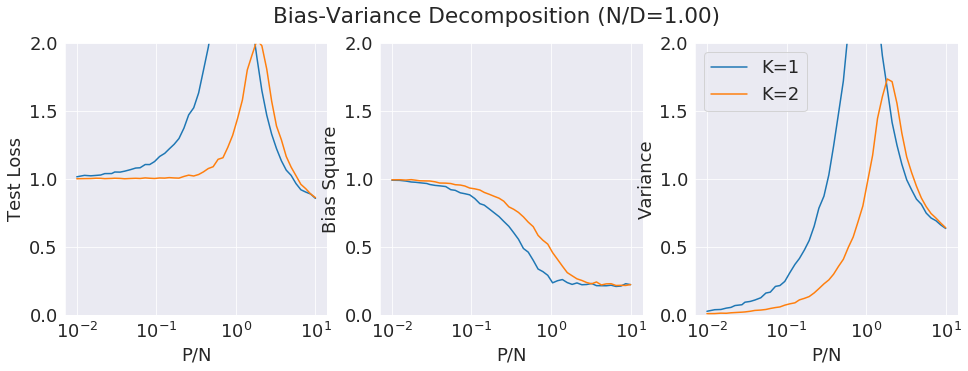

In [10]:
plot_single_vs_ensemble([K1_df, K2_df], [1, 2], N_Ds[0], feature_dim, ymax=2.0)